
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_9211/989867417.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


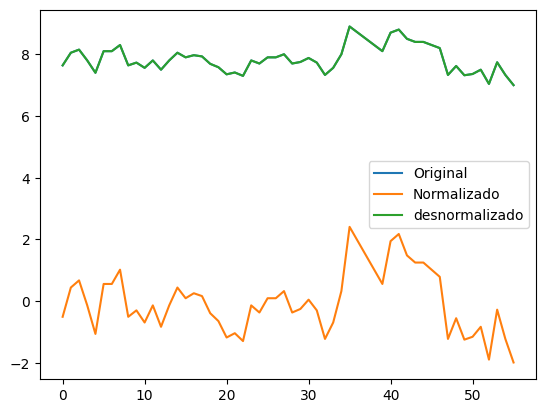

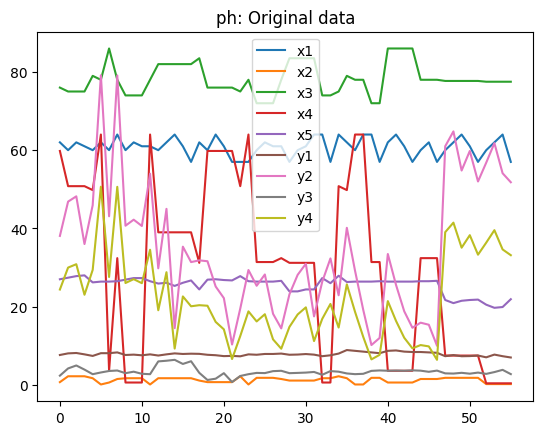

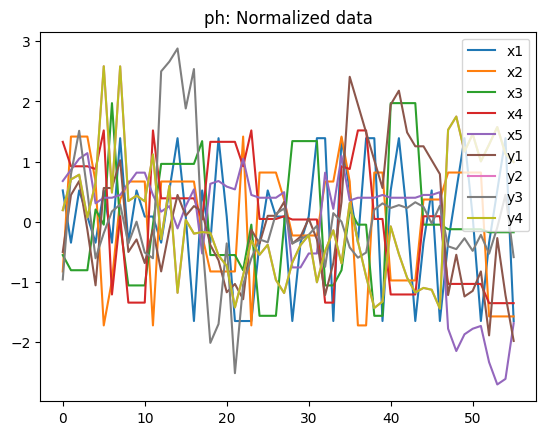

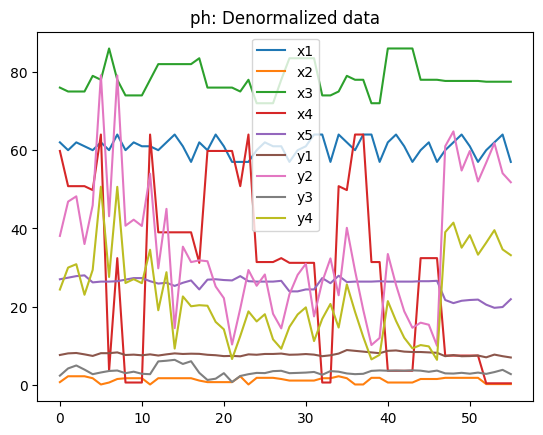

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y1"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y1")
test_out_scaler()
show_norm(label="ph")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-04 23:36:02.957680: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:36:05.292080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 23:36:05.292172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 23:36:05.634715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 23:36:06.397780: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:36:06.398712: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.9844248629999583
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.1990470529999584
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.2026410759999635
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.18794442800003708
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.17866101100003107
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.3116389470001195
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 +++++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_0,0.819618,0.609592,0.689150,0.669325,0.033745,0.039822,0.092547,0.064634
model_2_5_1,0.824496,0.610522,0.684575,0.666303,0.032833,0.039727,0.093909,0.065225
model_2_5_2,0.828107,0.611875,0.679113,0.662762,0.032157,0.039589,0.095536,0.065917
model_2_5_3,0.835128,0.612947,0.648779,0.641314,0.030844,0.039479,0.104567,0.070109
model_2_5_4,0.836120,0.653511,0.629244,0.638519,0.030658,0.035342,0.110383,0.070655
model_2_5_5,0.837323,0.654447,0.625463,0.636067,0.030433,0.035246,0.111509,0.071134
model_2_5_6,0.837639,0.658874,0.624651,0.636708,0.030374,0.034795,0.111750,0.071009
model_2_5_7,0.837775,0.660633,0.624163,0.636845,0.030349,0.034615,0.111895,0.070982
model_2_5_8,0.837913,0.662155,0.623565,0.636836,0.030323,0.034460,0.112074,0.070984
model_2_5_9,0.837970,0.662631,0.623393,0.636844,0.030312,0.034412,0.112125,0.070983


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.5143279189999248
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.2661426540000775
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.2624405639999168
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.3996138610000344
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.5364728950000881
Stopped at epoch:  11
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.6979242890001842
Stopped at epoch:  12
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.396307020

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.801469,0.479357,0.130669,0.463182,0.037141,0.07622,0.08056,0.078262


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.0354256319999422
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.041396007999992435
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.036907926999901974
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.02726531000007526
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.026990979999936826
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.033390093999969395
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.031

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.801447,0.886775,0.731675,0.826911,0.037145,0.020041,0.033660,0.026450
model_3_5_21,0.804363,0.423498,-0.108066,0.218419,0.036599,0.102042,0.139000,0.119434
model_3_5_20,0.806489,0.432741,-0.096068,0.228722,0.036202,0.100406,0.137495,0.117860
model_3_5_19,0.808817,0.443102,-0.082690,0.240244,0.035766,0.098572,0.135817,0.116099
model_3_5_18,0.811357,0.454698,-0.067753,0.253126,0.035291,0.096520,0.133943,0.114131
model_3_5_17,0.814119,0.467659,-0.051071,0.267518,0.034774,0.094226,0.131850,0.111931
model_3_5_16,0.817106,0.482115,-0.032443,0.283579,0.034215,0.091667,0.129514,0.109477
model_3_5_15,0.820316,0.498189,-0.011628,0.301477,0.033615,0.088822,0.126902,0.106742
model_3_5_1,0.821528,0.862289,0.663996,0.785751,0.033388,0.024375,0.042150,0.032740
model_3_5_14,0.823733,0.515986,0.011630,0.321375,0.032976,0.085672,0.123985,0.103701


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.27818803700006356
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.321772090000195
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.33029956500013213
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.27601686899993183
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.369369800999948
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.2945509859998765
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.29443244399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_9,0.812224,-0.302972,0.594910,0.344947,0.035129,0.110592,0.099915,0.105567
model_3_6_8,0.824110,-0.163667,0.624582,0.405159,0.032905,0.098768,0.092596,0.095864
model_3_6_0,0.831068,0.654840,0.824199,0.777146,0.031603,0.029296,0.043361,0.035915
model_3_6_7,0.835141,-0.020702,0.653135,0.465586,0.030841,0.086634,0.085554,0.086125
model_3_6_6,0.844769,0.121956,0.680336,0.524952,0.029040,0.074525,0.078845,0.076558
model_3_6_1,0.847487,0.637185,0.805715,0.758911,0.028532,0.030794,0.047920,0.038854
model_3_6_5,0.852410,0.259480,0.706397,0.582067,0.027611,0.062853,0.072417,0.067354
model_3_6_2,0.856158,0.581638,0.782309,0.726566,0.026910,0.035509,0.053693,0.044066
model_3_6_4,0.857416,0.386203,0.731852,0.635733,0.026674,0.052097,0.066138,0.058705
model_3_6_3,0.859005,0.495793,0.757198,0.684544,0.026377,0.042795,0.059887,0.050838


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.300126556999885
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.31229981699993914
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.3310490890000892
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.33942834499998753
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.24489826800004266
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3273869479999121
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.3332689029

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.836016,0.930839,0.976078,0.955852,0.030678,0.010783,0.004754,0.007946
model_3_7_1,0.863117,0.929523,0.968492,0.951307,0.025608,0.010988,0.006262,0.008764
model_3_7_2,0.881263,0.899676,0.961835,0.934159,0.022213,0.015642,0.007585,0.011850
model_3_7_3,0.892159,0.848054,0.955072,0.906971,0.020175,0.023690,0.008929,0.016744
model_3_7_4,0.898082,0.786899,0.947349,0.874912,0.019067,0.033225,0.010464,0.022514
model_3_7_5,0.901323,0.729333,0.937959,0.843633,0.018460,0.042200,0.012330,0.028143
model_3_7_22,0.902131,0.672936,0.653845,0.670137,0.018309,0.050993,0.068794,0.059370
model_3_7_21,0.902940,0.669273,0.664758,0.674128,0.018158,0.051564,0.066625,0.058651
model_3_7_6,0.903428,0.683556,0.926280,0.816571,0.018066,0.049337,0.014651,0.033014
model_3_7_20,0.903767,0.665157,0.676728,0.678460,0.018003,0.052206,0.064246,0.057872


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.3194942089999131
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.3910658170000261
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.336245788000042
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.35569688100008534
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.2845766539999204
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.4023787739999989
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.265987945999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_24,0.853357,0.385152,0.900695,0.664697,0.027434,0.145957,0.027415,0.090173
model_3_8_23,0.855931,0.395327,0.903417,0.670768,0.026952,0.143542,0.026664,0.088540
model_3_8_22,0.858717,0.406425,0.906331,0.677361,0.026431,0.140907,0.025859,0.086767
model_3_8_21,0.861721,0.418499,0.909440,0.684506,0.025869,0.138041,0.025001,0.084846
model_3_8_20,0.864951,0.431603,0.912744,0.692226,0.025265,0.134930,0.024089,0.082770
model_3_8_19,0.868408,0.445781,0.916243,0.700541,0.024618,0.131565,0.023123,0.080533
model_3_8_18,0.872091,0.461067,0.919932,0.709467,0.023929,0.127936,0.022104,0.078133
model_3_8_17,0.875994,0.477486,0.923804,0.719011,0.023199,0.124038,0.021035,0.075566
model_3_8_16,0.880105,0.495041,0.927853,0.729170,0.022430,0.119871,0.019917,0.072834
model_3_8_15,0.884406,0.513720,0.932067,0.739935,0.021625,0.115437,0.018754,0.069939


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.3871879069999977
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.2786150629999611
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.22924494299991238
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.3535315859999173
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.3359114209999916
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.24939624099988578
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.2911217289

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.842087,0.492742,0.482547,0.503826,0.029542,0.098815,0.095496,0.097253
model_3_9_23,0.843367,0.499481,0.483792,0.507924,0.029302,0.097502,0.095266,0.096450
model_3_9_22,0.844768,0.506876,0.485153,0.512418,0.029040,0.096062,0.095015,0.095569
model_3_9_21,0.846298,0.514980,0.486637,0.517339,0.028754,0.094483,0.094741,0.094604
model_3_9_20,0.847966,0.523845,0.488255,0.522721,0.028442,0.092756,0.094442,0.093550
model_3_9_19,0.849779,0.533522,0.490014,0.528591,0.028103,0.090871,0.094118,0.092399
model_3_9_18,0.851745,0.544064,0.491922,0.534983,0.027735,0.088817,0.093766,0.091146
model_3_9_17,0.853869,0.555515,0.493984,0.541922,0.027338,0.086587,0.093385,0.089786
model_3_9_16,0.856157,0.567918,0.496210,0.549434,0.026910,0.084171,0.092974,0.088314
model_3_9_15,0.858609,0.581302,0.498604,0.557537,0.026451,0.081563,0.092533,0.086726


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.5722301519999746
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.42987598199988497
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.380008294000163
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.43590075300016906
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.2519894590000149
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.33542885900010333
Stopped at epoch:  6
1/1 [==============================] - 0s 27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.801547,0.715782,0.658050,0.711033,0.037126,0.088392,0.015445,0.054064
model_4_4_4,0.802555,0.466007,0.781385,0.505239,0.036937,0.166072,0.009875,0.092567
model_4_4_3,0.808509,0.532599,0.762636,0.561711,0.035824,0.145362,0.010721,0.082002
model_4_4_1,0.809496,0.660157,0.703507,0.667247,0.035639,0.105691,0.013392,0.062256
model_4_4_2,0.811256,0.598050,0.737471,0.616451,0.035310,0.125006,0.011858,0.071760


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.28521481100005985
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.26979479100009485
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.348238333999916
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.21260748600002444
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.25964295599987963
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.2892570149999756
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.292703891

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_14,0.800415,0.362515,-1.527793,0.012351,0.037338,0.094548,0.145095,0.118335
model_4_5_13,0.804956,0.384361,-1.447246,0.044826,0.036488,0.091308,0.140472,0.114444
model_4_5_0,0.808940,0.850591,0.371277,0.760343,0.035743,0.022159,0.036089,0.028714
model_4_5_12,0.809566,0.407644,-1.359833,0.079791,0.035626,0.087854,0.135454,0.110254
model_4_5_11,0.814162,0.432378,-1.265243,0.117325,0.034766,0.084186,0.130025,0.105757
model_4_5_10,0.818644,0.458590,-1.163099,0.157531,0.033928,0.080299,0.124162,0.100940
model_4_5_1,0.821913,0.799283,0.191686,0.686231,0.033316,0.029769,0.046397,0.037594
model_4_5_9,0.822895,0.486361,-1.052921,0.200569,0.033132,0.076180,0.117838,0.095783
model_4_5_8,0.826780,0.515850,-0.934023,0.246699,0.032406,0.071806,0.111013,0.090256
model_4_5_2,0.829617,0.749258,0.005754,0.611530,0.031875,0.037189,0.057070,0.046544


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.494044145000089
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.3673377630000232
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.6248334249999061
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.4713888189999125
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.3236135380000178
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.37872792899997876
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.375876838000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.810255,0.625727,0.943605,0.772284,0.035497,0.053960,0.007770,0.032223
model_4_6_1,0.838405,0.647054,0.935756,0.780191,0.030231,0.050885,0.008851,0.031105
model_4_6_2,0.860248,0.661523,0.924587,0.782878,0.026144,0.048799,0.010390,0.030724
model_4_6_3,0.877067,0.670967,0.910488,0.781512,0.022998,0.047438,0.012333,0.030918
model_4_6_4,0.889847,0.676576,0.893747,0.776868,0.020607,0.046629,0.014639,0.031575
model_4_6_5,0.899370,0.679189,0.874733,0.769565,0.018826,0.046252,0.017259,0.032608
model_4_6_24,0.902947,0.598823,0.558081,0.581134,0.018157,0.057839,0.060885,0.059273
model_4_6_23,0.903975,0.601976,0.566086,0.586503,0.017964,0.057384,0.059783,0.058513
model_4_6_22,0.905074,0.605405,0.574895,0.592389,0.017759,0.056890,0.058569,0.057680
model_4_6_21,0.906241,0.609126,0.584573,0.598830,0.017540,0.056353,0.057235,0.056768


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.3667071089998899
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.3269513300001563
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.5151451799999904
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.3537297180000678
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.37356933299997763
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.3477013579999948
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.36313876999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.918227,0.829913,0.821717,0.828801,0.015298,0.022140,0.007722,0.015355
model_4_7_1,0.930287,0.843149,0.814083,0.837236,0.013042,0.020417,0.008052,0.014598
model_4_7_2,0.939762,0.854052,0.799024,0.842191,0.011269,0.018997,0.008704,0.014154
model_4_7_3,0.947162,0.863009,0.778381,0.844382,0.009885,0.017832,0.009599,0.013957
model_4_7_4,0.952899,0.870320,0.753812,0.844416,0.008812,0.016880,0.010663,0.013954
model_4_7_5,0.957306,0.876231,0.726747,0.842807,0.007987,0.016110,0.011835,0.014098
model_4_7_6,0.960654,0.880950,0.698373,0.839985,0.007361,0.015496,0.013064,0.014352
model_4_7_7,0.963163,0.884658,0.669619,0.836300,0.006891,0.015014,0.014309,0.014682
model_4_7_8,0.965010,0.887516,0.641186,0.832035,0.006546,0.014642,0.015541,0.015065
model_4_7_9,0.966337,0.889664,0.613578,0.827411,0.006298,0.014362,0.016736,0.015479


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.35674241799983974
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.37255953899989436
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.34187217099997724
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.3572534950001227
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.5874488629999632
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.3654687120001654
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.344864787

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.943694,0.904306,0.253209,0.831227,0.010534,0.032040,0.037582,0.034648
model_4_8_23,0.944246,0.905299,0.260632,0.832941,0.010430,0.031707,0.037209,0.034296
model_4_8_22,0.944852,0.906395,0.268843,0.834834,0.010317,0.031341,0.036795,0.033908
model_4_8_21,0.945519,0.907602,0.277916,0.836923,0.010192,0.030936,0.036339,0.033479
model_4_8_20,0.946250,0.908932,0.287937,0.839227,0.010055,0.030491,0.035835,0.033006
model_4_8_19,0.947051,0.910395,0.298994,0.841766,0.009906,0.030001,0.035278,0.032485
model_4_8_18,0.947926,0.912002,0.311180,0.844559,0.009742,0.029463,0.034665,0.031911
model_4_8_17,0.948881,0.913765,0.324601,0.847629,0.009563,0.028873,0.033989,0.031281
model_4_8_16,0.949919,0.915695,0.339357,0.850998,0.009369,0.028227,0.033247,0.030589
model_4_8_15,0.951043,0.917803,0.355554,0.854687,0.009159,0.027521,0.032432,0.029832


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.855299420999927
Stopped at epoch:  13
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.3401633050000328
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.32832917400014594
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.4071377800000846
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.37085229299987077
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.28546238800004176
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.461659694

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.918046,0.764997,0.640143,0.711694,0.015332,0.043655,0.058152,0.050478
model_4_9_23,0.918750,0.767829,0.642271,0.714209,0.015200,0.043129,0.057808,0.050037
model_4_9_22,0.919527,0.770950,0.644633,0.716988,0.015055,0.042549,0.057427,0.049551
model_4_9_21,0.920383,0.774389,0.647256,0.720059,0.014895,0.041911,0.057003,0.049013
model_4_9_20,0.921326,0.778171,0.650167,0.723447,0.014718,0.041208,0.056533,0.048420
model_4_9_19,0.922364,0.782326,0.653396,0.727184,0.014524,0.040436,0.056011,0.047765
model_4_9_18,0.923504,0.786885,0.656979,0.731301,0.014311,0.039589,0.055432,0.047045
model_4_9_17,0.924755,0.791879,0.660953,0.735833,0.014077,0.038662,0.054789,0.046251
model_4_9_16,0.926125,0.797339,0.665360,0.740814,0.013820,0.037647,0.054077,0.045379
model_4_9_15,0.927622,0.803295,0.670243,0.746280,0.013540,0.036541,0.053288,0.044422


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  1.0225959219999368
Stopped at epoch:  8
1/1 [==============================] - 0s 44ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.2975973239999803
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.36278518199992504
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.36359847199992146
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.37708427999996275
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.32575130400005037
Stopped at epoch:  6
1/1 [==============================] - 0s

2024-04-04 23:44:45.934987: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.38719300900015696
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_0] | 12 ++++++++++++++++++
Elapsed time:  0.3658795139999711
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_0] | 13 ++++++++++++++++++
Elapsed time:  0.37238880600011726
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 14 ++++++++++++++++++
Elapsed time:  0.35999771999991026
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 15 ++++++++++++++++++
Elapsed time:  0.37658230300007745
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_0] | 16 ++++++++++++++++++
Elapsed time:  0.3384365990000333
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 17 ++++++++++++++++++
Elapsed time:  0.3328981150000345
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/

2024-04-04 23:45:16.403865: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Elapsed time:  0.4039775759999884
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Elapsed time:  0.29549984599998425
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Elapsed time:  0.34675957500007826
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Elapsed time:  0.3958066659999986
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Elapsed time:  0.2612464199999067
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_2] | 8 ++++++++++++++++++
Elapsed time:  0.30306602199993904
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_2] | 9 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.805134,0.848334,0.603288,0.739707,0.036455,0.033056,0.080854,0.055550
model_5_3_1,0.820586,0.842699,0.581996,0.727092,0.033564,0.034285,0.085194,0.058242
model_5_3_2,0.832512,0.836570,0.562708,0.715109,0.031333,0.035620,0.089125,0.060799
model_5_3_3,0.841606,0.829999,0.545314,0.703739,0.029632,0.037053,0.092670,0.063226
model_5_3_4,0.848435,0.823070,0.529658,0.692957,0.028354,0.038563,0.095861,0.065527
model_5_3_5,0.853460,0.815891,0.515569,0.682744,0.027414,0.040127,0.098732,0.067706
model_5_3_6,0.857056,0.808573,0.502887,0.673087,0.026742,0.041722,0.101317,0.069767
model_5_3_18,0.858063,0.736418,0.420484,0.597041,0.026553,0.057449,0.118112,0.085996
model_5_3_17,0.858855,0.740623,0.424114,0.600946,0.026405,0.056533,0.117372,0.085163
model_5_3_7,0.859530,0.801225,0.491466,0.663982,0.026279,0.043324,0.103645,0.071710


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.29018827300023986
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.3862092599997595
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.3746218979999867
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.34042190099989966
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.3560699829999976
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.33660271899998406
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.375875718

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_19,0.800003,0.301016,0.378523,0.326655,0.037415,0.186815,0.050012,0.122437
model_5_4_18,0.803183,0.311577,0.395861,0.338483,0.036820,0.183993,0.048617,0.120287
model_5_4_17,0.806647,0.323311,0.414603,0.351519,0.036172,0.180856,0.047109,0.117916
model_5_4_16,0.810409,0.336346,0.434805,0.365869,0.035468,0.177373,0.045483,0.115307
model_5_4_15,0.814482,0.350822,0.456499,0.381652,0.034706,0.173504,0.043737,0.112437
model_5_4_14,0.818877,0.366892,0.479713,0.398991,0.033884,0.169209,0.041869,0.109284
model_5_4_13,0.823599,0.384718,0.504452,0.418014,0.033001,0.164444,0.039878,0.105825
model_5_4_12,0.828646,0.404475,0.530696,0.438854,0.032056,0.159164,0.037767,0.102036
model_5_4_11,0.834009,0.426349,0.558403,0.461645,0.031053,0.153318,0.035537,0.097892
model_5_4_10,0.839661,0.450520,0.587491,0.486512,0.029996,0.146858,0.033196,0.093370


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.2970120869999846
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.3796527149997928
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.37281685000016296
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.34528655699978117
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.3166290020003544
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.3633809860002657
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.3487924370

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.827347,0.977354,0.996899,0.986882,0.032300,0.005256,0.000538,0.003036
model_5_5_1,0.858588,0.978874,0.990761,0.985524,0.026455,0.004904,0.001602,0.003350
model_5_5_2,0.883089,0.979092,0.981420,0.982346,0.021871,0.004853,0.003222,0.004086
model_5_5_24,0.895996,0.738965,0.615894,0.725932,0.019457,0.060589,0.066618,0.063426
model_5_5_23,0.898138,0.745859,0.623606,0.732313,0.019056,0.058989,0.065280,0.061950
model_5_5_22,0.900481,0.753480,0.632191,0.739386,0.018618,0.057220,0.063791,0.060312
model_5_5_3,0.902040,0.977921,0.969047,0.977360,0.018326,0.005125,0.005368,0.005239
model_5_5_21,0.903035,0.761890,0.641735,0.747218,0.018140,0.055268,0.062136,0.058500
model_5_5_20,0.905808,0.771153,0.652329,0.755873,0.017621,0.053118,0.060299,0.056497
model_5_5_19,0.908801,0.781325,0.664062,0.765412,0.017061,0.050757,0.058264,0.054290


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.6197598119997565
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.3404043470000033
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.34124743699976534
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.38288357900000847
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.3405241569998907
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.4009623339998143
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.3220928649

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.942332,0.976781,0.890316,0.931180,0.010788,0.004999,0.030109,0.016816
model_5_6_1,0.947781,0.972891,0.892178,0.930351,0.009769,0.005836,0.029598,0.017018
model_5_6_24,0.951094,0.906348,0.850245,0.877142,0.009149,0.020162,0.041109,0.030019
model_5_6_23,0.951434,0.907368,0.851184,0.878114,0.009086,0.019942,0.040852,0.029782
model_5_6_2,0.951735,0.968597,0.892515,0.928526,0.009029,0.006761,0.029506,0.017464
model_5_6_22,0.951803,0.908495,0.852216,0.879186,0.009017,0.019699,0.040568,0.029520
model_5_6_21,0.952202,0.909740,0.853351,0.880366,0.008942,0.019432,0.040257,0.029232
model_5_6_20,0.952631,0.911112,0.854596,0.881664,0.008862,0.019136,0.039915,0.028914
model_5_6_19,0.953091,0.912625,0.855959,0.883091,0.008776,0.018810,0.039541,0.028566
model_5_6_18,0.953582,0.914291,0.857449,0.884655,0.008684,0.018452,0.039132,0.028184


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.4881104480000431
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.34367858699988574
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.3774673830002939
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.3658161700000164
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.34092727100005504
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.3377281469997797
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.3794312270

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.934665,0.737730,0.921683,0.838080,0.012223,0.055938,0.022332,0.040123
model_5_7_23,0.935904,0.743569,0.922706,0.841294,0.011991,0.054693,0.022040,0.039327
model_5_7_22,0.937255,0.749961,0.923834,0.844818,0.011738,0.053329,0.021719,0.038454
model_5_7_21,0.938725,0.756943,0.925079,0.848673,0.011463,0.051840,0.021364,0.037498
model_5_7_20,0.940317,0.764552,0.926450,0.852883,0.011165,0.050217,0.020973,0.036455
model_5_7_19,0.942038,0.772824,0.927960,0.857470,0.010843,0.048453,0.020542,0.035318
model_5_7_18,0.943890,0.781789,0.929619,0.862454,0.010497,0.046541,0.020069,0.034084
model_5_7_17,0.945872,0.791471,0.931440,0.867851,0.010126,0.044476,0.019550,0.032746
model_5_7_16,0.947981,0.801885,0.933434,0.873677,0.009732,0.042255,0.018981,0.031303
model_5_7_15,0.950212,0.813034,0.935614,0.879937,0.009314,0.039877,0.018360,0.029751


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.4000309489997562
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.38178819499989913
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.383578080999996
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.34336498999982723
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.41742836999992505
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.4052558120001777
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.3799891060

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.946364,0.979676,0.999352,0.988866,0.010034,0.003657,0.000104,0.001985
model_5_8_1,0.955745,0.978877,0.998980,0.988282,0.008279,0.003800,0.000163,0.002089
model_5_8_2,0.963263,0.977856,0.998497,0.987533,0.006873,0.003984,0.000240,0.002222
model_5_8_3,0.969283,0.976694,0.997940,0.986676,0.005746,0.004193,0.000329,0.002375
model_5_8_4,0.974099,0.975447,0.997335,0.985755,0.004846,0.004417,0.000426,0.002539
model_5_8_5,0.977943,0.974159,0.996704,0.984800,0.004126,0.004649,0.000527,0.002709
model_5_8_6,0.981005,0.972861,0.996062,0.983836,0.003553,0.004883,0.000630,0.002881
model_5_8_7,0.983439,0.971577,0.995423,0.982879,0.003098,0.005114,0.000732,0.003052
model_5_8_8,0.985365,0.970322,0.994796,0.981944,0.002738,0.005339,0.000832,0.003218
model_5_8_9,0.986886,0.969109,0.994187,0.981039,0.002453,0.005558,0.000930,0.003380


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.39065093999988676
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.4236602400001175
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.3688789560001169
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.3969115170002624
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.3700741409998045
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.4473503589997563
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.32879474200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.993796,0.992065,0.995847,0.994102,0.001161,0.001512,0.001037,0.001289
model_5_9_1,0.994472,0.991729,0.995584,0.993804,0.001034,0.001576,0.001103,0.001353
model_5_9_2,0.994978,0.991388,0.995211,0.993446,0.000940,0.001641,0.001196,0.001432
model_5_9_3,0.995350,0.991052,0.994766,0.993052,0.000870,0.001705,0.001307,0.001518
model_5_9_24,0.995534,0.987353,0.987575,0.987475,0.000836,0.002410,0.003103,0.002736
model_5_9_23,0.995565,0.987415,0.987716,0.987580,0.000830,0.002398,0.003068,0.002713
model_5_9_22,0.995598,0.987484,0.987872,0.987695,0.000823,0.002385,0.003029,0.002688
model_5_9_4,0.995619,0.990725,0.994279,0.992639,0.000820,0.001767,0.001429,0.001608
model_5_9_21,0.995634,0.987560,0.988043,0.987822,0.000817,0.002371,0.002986,0.002660
model_5_9_20,0.995672,0.987644,0.988230,0.987962,0.000810,0.002355,0.002939,0.002630


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.9496807669997906
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.5014128440002423
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.31580574200006595
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.35180556499972226
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.2811029919998873
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.33471241699999155
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_0,0.801541,0.279733,0.534513,0.401997,0.037127,0.139344,0.072150,0.107723
model_6_2_1,0.805689,0.279126,0.532574,0.400867,0.036351,0.139462,0.072450,0.107927
model_6_2_2,0.808870,0.278090,0.530226,0.399327,0.035756,0.139662,0.072814,0.108204
model_6_2_3,0.811290,0.276739,0.527700,0.397536,0.035303,0.139923,0.073206,0.108527
model_6_2_4,0.813113,0.275164,0.525146,0.395607,0.034962,0.140228,0.073602,0.108874
model_6_2_5,0.814468,0.273444,0.522661,0.393623,0.034709,0.140561,0.073987,0.109232
model_6_2_6,0.815458,0.271646,0.520292,0.391641,0.034524,0.140909,0.074354,0.109589
model_6_2_7,0.816164,0.269823,0.518069,0.389704,0.034392,0.141261,0.074699,0.109938
model_6_2_8,0.816650,0.268016,0.516002,0.387841,0.034301,0.141611,0.075019,0.110273
model_6_2_9,0.816968,0.266257,0.514092,0.386066,0.034241,0.141951,0.075315,0.110593


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.3597100929996486
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.3424053539997658
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.2749358609999035
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.4132242509999742
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.42659443399998054
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.3421500700001161
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.26617551300

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_3,0.806870,0.636423,0.290366,0.448655,0.036130,0.052119,0.141890,0.094364
model_6_3_2,0.815634,0.709696,0.350102,0.513986,0.034491,0.041615,0.129946,0.083183
model_6_3_1,0.821909,0.788612,0.403812,0.578506,0.033317,0.030303,0.119207,0.072140
model_6_3_0,0.823276,0.864559,0.446519,0.635661,0.033061,0.019416,0.110668,0.062358


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.42342181599997275
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.36854339000001346
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.3237551990000611
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.4239863719999448
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.37193125499970847
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.3348093479999079
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.374247898

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_16,0.800546,-0.165916,0.050781,0.120855,0.037313,0.125913,0.115609,0.121064
model_6_4_15,0.802508,-0.140664,0.054275,0.132793,0.036946,0.123186,0.115183,0.119420
model_6_4_14,0.804620,-0.113078,0.058828,0.146141,0.036551,0.120207,0.114629,0.117582
model_6_4_13,0.806887,-0.082962,0.064718,0.161096,0.036127,0.116955,0.113911,0.115523
model_6_4_12,0.809306,-0.050111,0.072232,0.177863,0.035675,0.113407,0.112996,0.113214
model_6_4_0,0.810062,0.611001,0.297051,0.545920,0.035533,0.042010,0.085615,0.062530
model_6_4_11,0.811862,-0.014304,0.081630,0.196641,0.035196,0.109540,0.111852,0.110628
model_6_4_10,0.814521,0.024684,0.093112,0.217608,0.034699,0.105329,0.110453,0.107741
model_6_4_9,0.817225,0.067077,0.106793,0.240903,0.034193,0.100751,0.108787,0.104533
model_6_4_1,0.818391,0.539053,0.275986,0.507280,0.033975,0.049780,0.088180,0.067851


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.4288055820002228
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step


2024-04-04 23:49:10.202181: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.3373076359998777
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.3274570839998887
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.35968669299973044
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.36424889099998836
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.32120318599982056
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.39811716199983493
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Elapsed time:  0.34001841700001023
Stopped at epoch:  6
1/1 [======

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_24,0.800348,-0.229231,-0.214712,0.096962,0.037350,0.172032,0.067521,0.122850
model_6_5_23,0.800893,-0.225203,-0.211635,0.099747,0.037249,0.171468,0.067350,0.122471
model_6_5_22,0.801481,-0.220756,-0.208308,0.102808,0.037138,0.170846,0.067165,0.122055
model_6_5_0,0.801662,0.174620,-0.221445,0.315615,0.037105,0.115512,0.067895,0.093104
model_6_5_21,0.802115,-0.215849,-0.204726,0.106169,0.037020,0.170159,0.066966,0.121597
model_6_5_20,0.802795,-0.210435,-0.200897,0.109855,0.036893,0.169401,0.066753,0.121096
model_6_5_19,0.803521,-0.204467,-0.196818,0.113889,0.036757,0.168566,0.066526,0.120547
model_6_5_18,0.804292,-0.197885,-0.192508,0.118303,0.036613,0.167645,0.066287,0.119947
model_6_5_17,0.805105,-0.190631,-0.187992,0.123121,0.036460,0.166630,0.066036,0.119291
model_6_5_16,0.805956,-0.182635,-0.183313,0.128376,0.036301,0.165511,0.065776,0.118576


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.3830367189998469
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.3339186289999816
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.34285857800023223
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.3651311630001146
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.37660874899984265
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.37048046800009615
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.375650842

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.871647,0.960890,0.944664,0.955882,0.024012,0.008895,0.012728,0.010699
model_6_7_1,0.890439,0.948712,0.945697,0.950297,0.020496,0.011665,0.012491,0.012054
model_6_7_2,0.904842,0.936413,0.944676,0.943735,0.017802,0.014463,0.012725,0.013645
model_6_7_3,0.915931,0.924670,0.942511,0.936937,0.015727,0.017133,0.013224,0.015293
model_6_7_4,0.924491,0.913782,0.939788,0.930316,0.014126,0.019610,0.013850,0.016899
model_6_7_5,0.931093,0.903813,0.936852,0.924056,0.012891,0.021877,0.014525,0.018417
model_6_7_6,0.936153,0.894710,0.933857,0.918199,0.011944,0.023948,0.015214,0.019838
model_6_7_24,0.939724,0.807655,0.874872,0.848647,0.011276,0.043748,0.028782,0.036705
model_6_7_7,0.939975,0.886364,0.930836,0.912707,0.011229,0.025846,0.015909,0.021170
model_6_7_23,0.940408,0.809942,0.877172,0.850809,0.011148,0.043228,0.028253,0.036181


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.6762933810000504
Stopped at epoch:  14
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.3692293479998625
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.44594360799965216
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.4013853609999387
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.33590325700015455
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.3337247770000431
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.347812379

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.927202,0.589384,0.739962,0.732222,0.013619,0.052015,0.036748,0.044831
model_6_8_23,0.927615,0.592054,0.741206,0.733786,0.013542,0.051677,0.036572,0.044569
model_6_8_22,0.928071,0.595009,0.742594,0.735521,0.013456,0.051303,0.036376,0.044279
model_6_8_21,0.928576,0.598278,0.744141,0.737445,0.013362,0.050889,0.036158,0.043956
model_6_8_20,0.929133,0.601895,0.745865,0.739578,0.013258,0.050431,0.035914,0.043599
model_6_8_19,0.929747,0.605890,0.747788,0.741942,0.013143,0.049925,0.035642,0.043203
model_6_8_18,0.930425,0.610303,0.749932,0.744562,0.013016,0.049365,0.035339,0.042765
model_6_8_17,0.931171,0.615174,0.752325,0.747464,0.012876,0.048748,0.035001,0.042279
model_6_8_16,0.931991,0.620545,0.754994,0.750676,0.012723,0.048068,0.034624,0.041741
model_6_8_15,0.932892,0.626464,0.757973,0.754230,0.012554,0.047318,0.034203,0.041146


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.37525966399971367
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.38788000900012776
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3329554379997717
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.33161483200001385
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.29946017600013874
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.32674838799994177
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.3776121

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.940971,0.945190,0.941664,0.949002,0.011043,0.006238,0.006878,0.006539
model_6_9_1,0.951547,0.952396,0.949353,0.955716,0.009065,0.005418,0.005971,0.005678
model_6_9_2,0.959646,0.957211,0.951478,0.958898,0.007549,0.004870,0.005721,0.005270
model_6_9_3,0.965816,0.960338,0.949672,0.959585,0.006395,0.004514,0.005934,0.005182
model_6_9_4,0.970480,0.962244,0.945141,0.958520,0.005523,0.004297,0.006468,0.005319
model_6_9_5,0.973965,0.963250,0.938773,0.956238,0.004871,0.004182,0.007219,0.005611
model_6_9_6,0.976527,0.963587,0.931225,0.953130,0.004391,0.004144,0.008109,0.006010
model_6_9_24,0.977826,0.945086,0.816793,0.894922,0.004148,0.006250,0.021600,0.013473
model_6_9_23,0.978127,0.945907,0.820050,0.896717,0.004092,0.006156,0.021216,0.013243
model_6_9_7,0.978370,0.963422,0.922978,0.949484,0.004046,0.004163,0.009081,0.006477


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.7893206019998615
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.37059949600006803
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.29038249499990343
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.3756436940002459
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.4677338729998155
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.41716769699996803
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_23,0.802769,-0.206324,0.225188,0.047260,0.036898,0.119426,0.121955,0.120616
model_7_2_0,0.803849,0.978461,0.983630,0.981505,0.036696,0.002132,0.002577,0.002341
model_7_2_22,0.806760,-0.173999,0.238467,0.068410,0.036151,0.116226,0.119865,0.117939
model_7_2_21,0.811092,-0.138711,0.253176,0.091627,0.035340,0.112732,0.117550,0.114999
model_7_2_20,0.815778,-0.100277,0.269465,0.117068,0.034464,0.108927,0.114986,0.111779
model_7_2_19,0.820827,-0.058537,0.287488,0.144893,0.033519,0.104795,0.112149,0.108256
model_7_2_18,0.826242,-0.013350,0.307417,0.175261,0.032506,0.100322,0.109012,0.104411
model_7_2_17,0.832014,0.035376,0.329432,0.208313,0.031426,0.095498,0.105547,0.100227
model_7_2_1,0.836418,0.957142,0.966181,0.962470,0.030602,0.004243,0.005323,0.004751
model_7_2_16,0.838124,0.087678,0.353722,0.244178,0.030283,0.090320,0.101724,0.095687


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.6586013020000792
Stopped at epoch:  11
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.39284976699991603
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.3489030659998207
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.33487668599991594
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.34928940700001476
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.33647692500017
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.3297576850

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_24,0.898909,-0.896590,0.884216,0.620861,0.018912,0.091416,0.029134,0.062106
model_7_3_23,0.899703,-0.876980,0.884503,0.624123,0.018763,0.090470,0.029061,0.061572
model_7_3_22,0.900574,-0.855220,0.884817,0.627740,0.018600,0.089422,0.028982,0.060980
model_7_3_21,0.901528,-0.831088,0.885160,0.631747,0.018422,0.088258,0.028896,0.060323
model_7_3_20,0.902571,-0.804334,0.885536,0.636186,0.018227,0.086969,0.028801,0.059596
model_7_3_19,0.903707,-0.774690,0.885944,0.641100,0.018014,0.085540,0.028699,0.058791
model_7_3_18,0.904942,-0.741864,0.886388,0.646534,0.017783,0.083958,0.028587,0.057901
model_7_3_17,0.906280,-0.705542,0.886868,0.652539,0.017533,0.082207,0.028466,0.056917
model_7_3_16,0.907723,-0.665402,0.887386,0.659166,0.017263,0.080272,0.028336,0.055832
model_7_3_15,0.909270,-0.621099,0.887940,0.666468,0.016974,0.078137,0.028196,0.054636


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.3488647660001334
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.31726385299998583
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.34906762400032676
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.43380493499989825
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.45724267600007806
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.27286398099977305
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.3200908

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.911063,0.944534,0.770465,0.849371,0.016638,0.004999,0.047823,0.025152
model_7_4_24,0.916680,0.882645,0.535438,0.693682,0.015587,0.010578,0.096791,0.051149
model_7_4_23,0.917755,0.885570,0.541241,0.697926,0.015386,0.010314,0.095582,0.050440
model_7_4_22,0.918916,0.888737,0.547577,0.702551,0.015169,0.010029,0.094262,0.049668
model_7_4_21,0.920165,0.892156,0.554480,0.707582,0.014935,0.009721,0.092823,0.048828
model_7_4_1,0.920260,0.955953,0.765707,0.849841,0.014918,0.003970,0.048815,0.025073
model_7_4_20,0.921503,0.895834,0.561981,0.713037,0.014685,0.009389,0.091261,0.047917
model_7_4_19,0.922928,0.899774,0.570108,0.718935,0.014418,0.009034,0.089567,0.046932
model_7_4_18,0.924436,0.903975,0.578883,0.725288,0.014136,0.008655,0.087739,0.045871
model_7_4_17,0.926020,0.908432,0.588319,0.732102,0.013840,0.008254,0.085773,0.044733


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.3700791430001118
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.3590696700002809
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.39077590599981704
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.31424348400014424
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.35333908900020106
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.37169619499991313
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.44727801

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.930557,0.969903,0.934344,0.948703,0.012991,0.002501,0.009326,0.005713
model_7_5_1,0.940600,0.957185,0.929608,0.940837,0.011112,0.003557,0.009999,0.006589
model_7_5_24,0.946938,0.668003,0.732827,0.708501,0.009927,0.027585,0.037952,0.032464
model_7_5_23,0.947438,0.671390,0.736031,0.711762,0.009833,0.027304,0.037496,0.032100
model_7_5_2,0.947657,0.938057,0.921766,0.928575,0.009792,0.005147,0.011113,0.007954
model_7_5_22,0.947981,0.675167,0.739576,0.715382,0.009732,0.026990,0.036993,0.031697
model_7_5_21,0.948570,0.679380,0.743496,0.719399,0.009621,0.026640,0.036436,0.031250
model_7_5_20,0.949207,0.684084,0.747831,0.723858,0.009502,0.026249,0.035820,0.030753
model_7_5_19,0.949893,0.689334,0.752617,0.728805,0.009374,0.025813,0.035140,0.030202
model_7_5_18,0.950626,0.695197,0.757898,0.734290,0.009237,0.025326,0.034390,0.029591


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.34177122899973256
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.3289971620001779
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.3719533240000601
Stopped at epoch:  6
1/1 [==============================] - 0s 86ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.4047133570002188
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.34116867699958675
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.3545478290002393
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.3838035250

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_24,0.889460,0.981537,-2.283985,0.556820,0.020680,0.003652,0.140426,0.068016
model_7_6_23,0.890516,0.981777,-2.251674,0.561220,0.020482,0.003605,0.139045,0.067341
model_7_6_22,0.891679,0.982040,-2.215923,0.566087,0.020264,0.003552,0.137516,0.066594
model_7_6_21,0.892958,0.982329,-2.176402,0.571466,0.020025,0.003495,0.135826,0.065769
model_7_6_20,0.894363,0.982647,-2.132725,0.577410,0.019762,0.003432,0.133958,0.064856
model_7_6_19,0.895905,0.982995,-2.084501,0.583970,0.019474,0.003363,0.131896,0.063849
model_7_6_18,0.897593,0.983376,-2.031293,0.591207,0.019158,0.003288,0.129621,0.062739
model_7_6_17,0.899438,0.983792,-1.972642,0.599181,0.018813,0.003206,0.127113,0.061515
model_7_6_16,0.901450,0.984245,-1.908061,0.607958,0.018437,0.003116,0.124351,0.060168
model_7_6_15,0.903638,0.984739,-1.837042,0.617606,0.018027,0.003019,0.121315,0.058687


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.5037396309999167
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.3168451670003378
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.2949953629999982
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.3986704090002604
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.37314123699979973
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.4082638079999015
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.34584200199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.910689,0.988424,0.991399,0.991676,0.016708,0.002994,0.001597,0.002337
model_7_7_1,0.927239,0.990146,0.989751,0.992003,0.013612,0.002549,0.001903,0.002245
model_7_7_2,0.940108,0.990677,0.986521,0.991257,0.011204,0.002411,0.002503,0.002454
model_7_7_3,0.950066,0.990324,0.982111,0.989712,0.009342,0.002503,0.003321,0.002888
model_7_7_4,0.957715,0.989320,0.976858,0.987587,0.007911,0.002762,0.004297,0.003484
model_7_7_5,0.963535,0.987844,0.971041,0.985057,0.006822,0.003144,0.005377,0.004195
model_7_7_6,0.967906,0.986045,0.964894,0.982265,0.006004,0.003610,0.006518,0.004978
model_7_7_7,0.971137,0.984037,0.958602,0.979328,0.005400,0.004129,0.007686,0.005803
model_7_7_8,0.973473,0.981915,0.952316,0.976336,0.004963,0.004678,0.008853,0.006643
model_7_7_24,0.974132,0.957487,0.887981,0.944395,0.004839,0.010996,0.020799,0.015609


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.44827409399977114
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.34645712800011097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.4551083490000565
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.3402249620003204
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.35790661900000487
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.3297467349998442
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.368622996

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.982219,0.946202,0.985641,0.962503,0.003327,0.011540,0.002286,0.007185
model_7_8_1,0.983877,0.949193,0.985174,0.964094,0.003016,0.010899,0.002360,0.006880
model_7_8_2,0.985184,0.951590,0.984539,0.965266,0.002772,0.010385,0.002461,0.006656
model_7_8_3,0.986211,0.953511,0.983795,0.966114,0.002580,0.009972,0.002579,0.006493
model_7_8_4,0.987016,0.955053,0.982990,0.966713,0.002429,0.009642,0.002707,0.006379
model_7_8_5,0.987643,0.956291,0.982156,0.967120,0.002312,0.009376,0.002840,0.006300
model_7_8_6,0.988130,0.957285,0.981318,0.967382,0.002221,0.009163,0.002974,0.006250
model_7_8_7,0.988506,0.958085,0.980494,0.967534,0.002150,0.008991,0.003105,0.006221
model_7_8_8,0.988794,0.958728,0.979697,0.967604,0.002096,0.008853,0.003232,0.006208
model_7_8_9,0.989012,0.959247,0.978934,0.967613,0.002056,0.008742,0.003353,0.006206


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.316374936000102
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.43958024499988824
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.3525118949996795
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.6228904320000765
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.3507536910001363
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.4741390969998065
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.370472435000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.981581,0.875626,0.936056,0.931460,0.003446,0.009103,0.013825,0.011325
model_7_9_23,0.981839,0.877067,0.937130,0.932459,0.003397,0.008997,0.013592,0.011160
model_7_9_22,0.982122,0.878653,0.938313,0.933560,0.003344,0.008881,0.013337,0.010978
model_7_9_21,0.982432,0.880396,0.939616,0.934771,0.003287,0.008754,0.013055,0.010778
model_7_9_20,0.982770,0.882308,0.941049,0.936102,0.003223,0.008614,0.012745,0.010558
model_7_9_19,0.983139,0.884402,0.942622,0.937562,0.003154,0.008460,0.012405,0.010317
model_7_9_18,0.983540,0.886694,0.944347,0.939161,0.003079,0.008293,0.012032,0.010052
model_7_9_17,0.983974,0.889194,0.946236,0.940910,0.002998,0.008110,0.011624,0.009763
model_7_9_16,0.984443,0.891917,0.948299,0.942819,0.002910,0.007910,0.011178,0.009448
model_7_9_15,0.984947,0.894876,0.950547,0.944897,0.002816,0.007694,0.010692,0.009105


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.6006852580003397
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.4167396500001814
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.33977301000004445
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.35862324600020656
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.41705892100026176
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.4005077869996967
Stopped at epoch:  6
1/1 [==============================] - 0s 2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.815464,0.057947,0.861372,0.663773,0.034523,0.085715,0.043363,0.065785
model_8_2_1,0.832627,0.064791,0.869143,0.671305,0.031312,0.085092,0.040932,0.064311
model_8_2_2,0.846424,0.070159,0.875046,0.677068,0.028731,0.084604,0.039086,0.063184
model_8_2_3,0.857338,0.073842,0.878942,0.680906,0.026689,0.084269,0.037867,0.062433
model_8_2_4,0.865809,0.075798,0.880881,0.682846,0.025104,0.084091,0.037260,0.062053
model_8_2_5,0.872234,0.076117,0.881030,0.683037,0.023902,0.084062,0.037214,0.062016
model_8_2_6,0.876967,0.074985,0.879629,0.681704,0.023017,0.084165,0.037652,0.062277
model_8_2_18,0.880124,0.022049,0.825474,0.627929,0.022426,0.088981,0.054592,0.072798
model_8_2_7,0.880321,0.072630,0.876950,0.679109,0.022389,0.084379,0.038490,0.062784
model_8_2_17,0.881015,0.026310,0.829530,0.632029,0.022259,0.088594,0.053323,0.071996


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.3658243129998482
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.30974525400006314
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.29447804699975677
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.34962634800012893
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.3662405619998026
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.4202749999999469
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.493282470

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_24,0.807830,0.480527,0.709825,0.606182,0.035951,0.174387,0.055155,0.118277
model_8_3_23,0.809299,0.484731,0.711983,0.609312,0.035676,0.172975,0.054744,0.117337
model_8_3_22,0.810914,0.489376,0.714365,0.612770,0.035374,0.171416,0.054292,0.116299
model_8_3_21,0.812687,0.494503,0.716989,0.616586,0.035042,0.169695,0.053793,0.115153
model_8_3_20,0.814631,0.500157,0.719877,0.620792,0.034678,0.167797,0.053244,0.113889
model_8_3_19,0.816755,0.506386,0.723046,0.625421,0.034281,0.165706,0.052642,0.112499
model_8_3_18,0.819073,0.513238,0.726515,0.630509,0.033847,0.163405,0.051982,0.110971
model_8_3_17,0.821592,0.520765,0.730300,0.636090,0.033376,0.160879,0.051263,0.109295
model_8_3_16,0.824322,0.529019,0.734413,0.642200,0.032865,0.158108,0.050481,0.107460
model_8_3_15,0.827267,0.538052,0.738859,0.648869,0.032314,0.155075,0.049636,0.105457


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.41688195599999744
Stopped at epoch:  7
1/1 [==============================] - 0s 39ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.4275647949998529
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.35406934299999193
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.35909584799992444
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.25976815600006375
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.3528992159999689
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.35768563

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.867037,0.803663,0.990263,0.926561,0.024874,0.023168,0.002474,0.013430
model_8_4_1,0.885726,0.792235,0.982494,0.917577,0.021378,0.024516,0.004449,0.015073
model_8_4_24,0.889245,0.309394,0.793635,0.629129,0.020720,0.081492,0.052442,0.067821
model_8_4_23,0.890699,0.318507,0.797219,0.634585,0.020448,0.080416,0.051531,0.066823
model_8_4_22,0.892276,0.328538,0.801150,0.640582,0.020153,0.079233,0.050533,0.065727
model_8_4_21,0.893979,0.339566,0.805457,0.647166,0.019834,0.077931,0.049438,0.064523
model_8_4_20,0.895811,0.351674,0.810168,0.654383,0.019491,0.076502,0.048241,0.063203
model_8_4_19,0.897772,0.364947,0.815311,0.662281,0.019125,0.074936,0.046934,0.061759
model_8_4_2,0.899250,0.773787,0.973194,0.905193,0.018848,0.026693,0.006812,0.017337
model_8_4_18,0.899860,0.379470,0.820915,0.670907,0.018734,0.073223,0.045510,0.060181


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.4299760160001824
Stopped at epoch:  7
1/1 [==============================] - 0s 35ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.3166274519999206
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3250187669996194
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.3339343489997191
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.34608714100022553
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.34044898999991346
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.4276655979

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.904655,0.831119,0.646021,0.742658,0.017837,0.035058,0.084919,0.058522
model_8_5_23,0.905914,0.831734,0.652784,0.746311,0.017601,0.034930,0.083297,0.057691
model_8_5_22,0.907281,0.832406,0.660187,0.750312,0.017346,0.034791,0.081521,0.056781
model_8_5_21,0.908758,0.833140,0.668279,0.754684,0.017069,0.034638,0.079580,0.055787
model_8_5_20,0.910349,0.833941,0.677101,0.759450,0.016772,0.034472,0.077463,0.054703
model_8_5_19,0.912055,0.834814,0.686696,0.764636,0.016452,0.034291,0.075162,0.053524
model_8_5_18,0.913876,0.835766,0.697101,0.770261,0.016112,0.034093,0.072665,0.052245
model_8_5_17,0.915806,0.836804,0.708349,0.776347,0.015751,0.033877,0.069967,0.050861
model_8_5_0,0.917570,0.885296,0.982605,0.935932,0.015421,0.023811,0.004173,0.014570
model_8_5_16,0.917840,0.837941,0.720466,0.782911,0.015370,0.033642,0.067060,0.049368


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.3682087780002803
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.6556425809999382
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.3638775489998807
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.35130039499972554
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.36827554199999213
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.41078470699994796
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.292378857

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.921800,0.991265,0.862164,0.971700,0.014630,0.001829,0.008868,0.005141
model_8_6_1,0.935008,0.990635,0.863591,0.971553,0.012159,0.001961,0.008776,0.005168
model_8_6_2,0.945034,0.987935,0.859252,0.969183,0.010283,0.002526,0.009055,0.005598
model_8_6_3,0.952500,0.983625,0.850232,0.965050,0.008886,0.003428,0.009635,0.006349
model_8_6_24,0.953443,0.868219,0.543910,0.843591,0.008710,0.027588,0.029343,0.028414
model_8_6_23,0.954188,0.870900,0.551416,0.846477,0.008570,0.027027,0.028860,0.027890
model_8_6_22,0.954991,0.873841,0.559637,0.849641,0.008420,0.026412,0.028331,0.027315
model_8_6_21,0.955851,0.877061,0.568626,0.853104,0.008259,0.025737,0.027753,0.026686
model_8_6_20,0.956768,0.880580,0.578436,0.856886,0.008088,0.025001,0.027122,0.025999
model_8_6_19,0.957738,0.884418,0.589114,0.861007,0.007906,0.024197,0.026435,0.025250


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.3952112750002925
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.294450242000039
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.37718141499999547
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.34575138500031244
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.35492585900010454
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.365880479000225
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.32959543199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.960518,0.914135,0.744748,0.884179,0.007386,0.026853,0.021256,0.024219
model_8_7_23,0.961296,0.915979,0.749857,0.886596,0.007241,0.026276,0.020831,0.023713
model_8_7_22,0.962145,0.918006,0.755469,0.889253,0.007082,0.025642,0.020363,0.023158
model_8_7_21,0.963069,0.920229,0.761625,0.892167,0.006909,0.024947,0.019851,0.022549
model_8_7_0,0.963372,0.968528,0.998344,0.974771,0.006852,0.009842,0.000138,0.005275
model_8_7_20,0.964072,0.922664,0.768367,0.895358,0.006721,0.024185,0.019289,0.021881
model_8_7_19,0.965157,0.925325,0.775736,0.898846,0.006518,0.023353,0.018676,0.021152
model_8_7_18,0.966325,0.928226,0.783775,0.902649,0.006300,0.022446,0.018006,0.020357
model_8_7_17,0.967578,0.931378,0.792522,0.906784,0.006065,0.021460,0.017278,0.019492
model_8_7_16,0.968912,0.934791,0.802013,0.911265,0.005816,0.020393,0.016487,0.018555


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.3030312089999825
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.331133834999946
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.37424984100016445
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.4320463600001858
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.27778387299986207
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.42403431299999284
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.3871616049

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.967830,0.921238,0.937535,0.929656,0.006018,0.006297,0.005459,0.005903
model_8_8_1,0.973449,0.932915,0.945292,0.939348,0.004967,0.005364,0.004781,0.005090
model_8_8_2,0.977721,0.940294,0.949571,0.945167,0.004168,0.004774,0.004407,0.004601
model_8_8_3,0.980932,0.944350,0.951283,0.948053,0.003567,0.004450,0.004258,0.004359
model_8_8_4,0.983310,0.945888,0.951143,0.948760,0.003122,0.004327,0.004270,0.004300
model_8_8_5,0.985038,0.945554,0.949697,0.947882,0.002799,0.004353,0.004396,0.004374
model_8_8_24,0.985560,0.888816,0.900205,0.895006,0.002701,0.008890,0.008722,0.008811
model_8_8_23,0.985739,0.890581,0.901584,0.896572,0.002668,0.008749,0.008601,0.008679
model_8_8_22,0.985931,0.892512,0.903095,0.898287,0.002632,0.008594,0.008469,0.008535
model_8_8_21,0.986135,0.894619,0.904751,0.900161,0.002594,0.008426,0.008325,0.008378


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.6990265270001146
Stopped at epoch:  13
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.2847062169998935
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.44210189500017805
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.3021489869997822
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.3519710830000804
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.3631911669999681
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.3790857069

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.989630,0.948034,0.986649,0.965048,0.001940,0.010043,0.002264,0.006382
model_8_9_23,0.989686,0.948350,0.986698,0.965247,0.001930,0.009982,0.002255,0.006346
model_8_9_22,0.989747,0.948700,0.986753,0.965467,0.001918,0.009915,0.002246,0.006306
model_8_9_21,0.989814,0.949087,0.986813,0.965710,0.001906,0.009840,0.002236,0.006262
model_8_9_20,0.989888,0.949514,0.986879,0.965978,0.001892,0.009757,0.002225,0.006213
model_8_9_19,0.989968,0.949987,0.986952,0.966275,0.001877,0.009666,0.002212,0.006158
model_8_9_18,0.990056,0.950508,0.987031,0.966602,0.001860,0.009565,0.002199,0.006099
model_8_9_17,0.990152,0.951084,0.987119,0.966963,0.001842,0.009454,0.002184,0.006033
model_8_9_16,0.990256,0.951719,0.987215,0.967361,0.001823,0.009331,0.002168,0.005960
model_8_9_15,0.990369,0.952419,0.987321,0.967799,0.001802,0.009196,0.002150,0.005880


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.6935123319999548
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.43622886799994376
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3805272499998864
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.3370989289996942
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.394797866999852
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3832998050002061
Stopped at epoch:  6
1/1 [==============================] - 0s 16m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.821519,0.973861,0.800100,0.933285,0.033390,0.006675,0.017515,0.011776
model_9_2_1,0.844958,0.964847,0.729079,0.909791,0.029005,0.008976,0.023738,0.015923
model_9_2_2,0.860045,0.952626,0.632343,0.877834,0.026183,0.012097,0.032214,0.021564
model_9_2_23,0.868599,0.837107,-0.410581,0.545738,0.024582,0.041596,0.123593,0.080183
model_9_2_22,0.869865,0.840553,-0.398440,0.551213,0.024345,0.040716,0.122530,0.079216
model_9_2_3,0.870094,0.941019,0.526869,0.844306,0.024302,0.015061,0.041455,0.027482
model_9_2_21,0.871217,0.844278,-0.384857,0.557239,0.024092,0.039765,0.121339,0.078153
model_9_2_20,0.872654,0.848287,-0.369645,0.563862,0.023824,0.038741,0.120007,0.076984
model_9_2_19,0.874168,0.852578,-0.352586,0.571134,0.023540,0.037645,0.118512,0.075700
model_9_2_18,0.875751,0.857145,-0.333426,0.579108,0.023244,0.036479,0.116833,0.074293


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.37472578599999906
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.368118633999984
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.3480483329999515
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.3135676050001166
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.3610527830001047
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.34421663500006616
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.38737669500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.911297,0.981082,0.986799,0.983494,0.016594,0.004256,0.002341,0.003355
model_9_3_1,0.926290,0.980103,0.982408,0.981118,0.013790,0.004476,0.003120,0.003838
model_9_3_2,0.938148,0.978982,0.977099,0.978281,0.011571,0.004728,0.004061,0.004414
model_9_3_3,0.947502,0.977821,0.971223,0.975188,0.009821,0.004989,0.005104,0.005043
model_9_3_4,0.954858,0.976689,0.965055,0.971992,0.008445,0.005244,0.006198,0.005693
model_9_3_5,0.960625,0.975626,0.958811,0.968805,0.007366,0.005483,0.007305,0.006340
model_9_3_6,0.965127,0.974651,0.952655,0.965706,0.006524,0.005702,0.008397,0.006970
model_9_3_7,0.968628,0.973771,0.946701,0.962746,0.005869,0.005900,0.009453,0.007572
model_9_3_8,0.971336,0.972984,0.941030,0.959956,0.005362,0.006077,0.010458,0.008139
model_9_3_9,0.973416,0.972281,0.935692,0.957352,0.004973,0.006236,0.011405,0.008668


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.37339416699978756
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.3423719299998993
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.3422662580001088
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.3317902140001934
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.3526999719997548
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.31177265399992393
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.4747505159

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.974065,0.885355,0.891895,0.894644,0.004852,0.015719,0.016148,0.015921
model_9_4_23,0.974490,0.887397,0.893718,0.896473,0.004772,0.015439,0.015876,0.015645
model_9_4_22,0.974955,0.889638,0.895728,0.898485,0.004685,0.015132,0.015575,0.015341
model_9_4_21,0.975461,0.892094,0.897941,0.900694,0.004591,0.014795,0.015245,0.015007
model_9_4_20,0.976011,0.894780,0.900376,0.903117,0.004488,0.014427,0.014881,0.014641
model_9_4_19,0.976607,0.897713,0.903050,0.905769,0.004376,0.014025,0.014482,0.014240
model_9_4_18,0.977251,0.900908,0.905983,0.908669,0.004256,0.013587,0.014044,0.013802
model_9_4_17,0.977944,0.904381,0.909195,0.911831,0.004126,0.013111,0.013564,0.013324
model_9_4_16,0.978685,0.908143,0.912705,0.915271,0.003988,0.012595,0.013040,0.012804
model_9_4_15,0.979474,0.912207,0.916533,0.919003,0.003840,0.012038,0.012468,0.012240


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.5780478000001494
Stopped at epoch:  10
1/1 [==============================] - 0s 29ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.3520443530001103
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.4457527189997563
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.3820009430000937
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.4082081550000112
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.31267603300011615
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.3515867589

2024-04-04 23:58:25.024520: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++++
Elapsed time:  0.3008261350000794
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 10 ++++++++++++++++++
Elapsed time:  0.3349939419999828
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_5] | 11 ++++++++++++++++++
Elapsed time:  0.40952629899993553
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 12 ++++++++++++++++++
Elapsed time:  0.435032111000055
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 13 ++++++++++++++++++
Elapsed time:  0.37454499100022076
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 14 ++++++++++++++++++
Elapsed time:  0.374353315999997
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 15 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.984405,0.970271,0.825211,0.961381,0.002917,0.008469,0.003836,0.006289
model_9_5_24,0.984406,0.957369,0.694114,0.941117,0.002917,0.012145,0.006714,0.009589
model_9_5_23,0.984480,0.957539,0.696566,0.941431,0.002903,0.012096,0.006660,0.009538
model_9_5_22,0.984562,0.957727,0.699264,0.941776,0.002888,0.012042,0.006601,0.009482
model_9_5_21,0.984650,0.957936,0.702227,0.942157,0.002872,0.011983,0.006536,0.009420
model_9_5_20,0.984746,0.958165,0.705475,0.942575,0.002854,0.011918,0.006464,0.009351
model_9_5_19,0.984848,0.958418,0.709036,0.943035,0.002835,0.011846,0.006386,0.009277
model_9_5_18,0.984959,0.958697,0.712923,0.943540,0.002814,0.011766,0.006301,0.009194
model_9_5_17,0.985077,0.959004,0.717165,0.944094,0.002792,0.011679,0.006208,0.009104
model_9_5_1,0.985164,0.969359,0.822745,0.960380,0.002775,0.008729,0.003890,0.006452


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.6555724320000991
Stopped at epoch:  11
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.29611953399989943
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.3502402969998002
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.467750494000029
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.36374080799987496
Stopped at epoch:  6
1/1 [==============================] - 0s 86ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.3927351649999764
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.3449040860

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.989830,0.982490,0.976203,0.979036,0.001903,0.003549,0.006676,0.005020
model_9_6_1,0.990143,0.982268,0.976049,0.978851,0.001844,0.003594,0.006719,0.005064
model_9_6_2,0.990372,0.982034,0.975855,0.978640,0.001801,0.003641,0.006774,0.005115
model_9_6_24,0.990396,0.978906,0.972372,0.975318,0.001797,0.004275,0.007751,0.005911
model_9_6_23,0.990415,0.978957,0.972434,0.975375,0.001793,0.004265,0.007733,0.005897
model_9_6_22,0.990436,0.979014,0.972503,0.975438,0.001789,0.004253,0.007714,0.005882
model_9_6_21,0.990458,0.979076,0.972579,0.975508,0.001785,0.004241,0.007693,0.005865
model_9_6_20,0.990483,0.979144,0.972663,0.975585,0.001780,0.004227,0.007669,0.005847
model_9_6_19,0.990508,0.979220,0.972754,0.975669,0.001776,0.004211,0.007644,0.005826
model_9_6_18,0.990536,0.979303,0.972855,0.975762,0.001771,0.004194,0.007615,0.005804


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.37890442600019014
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.3189950159999171
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3880008200003431
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.5944143040001109
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.3531443409997337
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3227995299998838
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.30634344999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.991431,0.936956,0.982628,0.971187,0.001603,0.005571,0.004892,0.005252
model_9_7_23,0.991575,0.938099,0.982943,0.971710,0.001576,0.005470,0.004804,0.005156
model_9_7_22,0.991731,0.939354,0.983290,0.972284,0.001547,0.005359,0.004706,0.005052
model_9_7_21,0.991901,0.940730,0.983669,0.972913,0.001515,0.005237,0.004599,0.004937
model_9_7_20,0.992084,0.942237,0.984085,0.973602,0.001481,0.005104,0.004482,0.004811
model_9_7_0,0.992099,0.995755,0.998791,0.998031,0.001478,0.000375,0.000340,0.000359
model_9_7_19,0.992281,0.943885,0.984539,0.974355,0.001444,0.004959,0.004354,0.004674
model_9_7_18,0.992492,0.945681,0.985034,0.975176,0.001405,0.004800,0.004215,0.004525
model_9_7_17,0.992718,0.947636,0.985573,0.976069,0.001362,0.004627,0.004063,0.004362
model_9_7_16,0.992957,0.949757,0.986157,0.977039,0.001318,0.004440,0.003898,0.004185


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.31609541899979376
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.41446948100019654
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.4817524619998039
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.34575394600005893
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.3024936459996752
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.32288882299963007
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.51113132

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.992997,0.989011,0.998064,0.992689,0.001310,0.001725,0.000233,0.001023
model_9_8_1,0.994188,0.990976,0.997088,0.993462,0.001087,0.001416,0.000350,0.000914
model_9_8_2,0.995082,0.992271,0.995970,0.993779,0.000920,0.001213,0.000484,0.000870
model_9_8_3,0.995743,0.993053,0.994766,0.993757,0.000796,0.001090,0.000629,0.000873
model_9_8_24,0.996086,0.986178,0.978020,0.982904,0.000732,0.002169,0.002641,0.002391
model_9_8_23,0.996141,0.986429,0.978336,0.983181,0.000722,0.002130,0.002603,0.002352
model_9_8_22,0.996200,0.986704,0.978685,0.983485,0.000711,0.002087,0.002561,0.002310
model_9_8_4,0.996221,0.993445,0.993520,0.993486,0.000707,0.001029,0.000779,0.000911
model_9_8_21,0.996263,0.987002,0.979069,0.983817,0.000699,0.002040,0.002515,0.002263
model_9_8_20,0.996330,0.987326,0.979491,0.984180,0.000686,0.001989,0.002464,0.002213


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.38036315299996204
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.3334168950000276
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.4419558570002664
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.375446262999958
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.38191868200010504
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.40598866800019096
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.3910082339

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.989086,0.970636,0.894688,0.947351,0.002042,0.004656,0.009040,0.006719
model_9_9_23,0.989223,0.970993,0.896076,0.948025,0.002016,0.004600,0.008921,0.006633
model_9_9_22,0.989374,0.971385,0.897607,0.948768,0.001988,0.004538,0.008790,0.006539
model_9_9_21,0.989539,0.971817,0.899294,0.949586,0.001957,0.004469,0.008645,0.006434
model_9_9_20,0.989721,0.972292,0.901151,0.950486,0.001923,0.004394,0.008486,0.006319
model_9_9_19,0.989920,0.972812,0.903193,0.951474,0.001886,0.004311,0.008310,0.006193
model_9_9_18,0.990137,0.973382,0.905435,0.952558,0.001845,0.004221,0.008118,0.006055
model_9_9_17,0.990374,0.974004,0.907893,0.953746,0.001801,0.004122,0.007907,0.005903
model_9_9_16,0.990632,0.974682,0.910584,0.955044,0.001752,0.004015,0.007676,0.005738
model_9_9_15,0.990912,0.975420,0.913524,0.956460,0.001700,0.003898,0.007423,0.005557


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.9365953430001355
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  1.284828787999686
Stopped at epoch:  22
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.22963046599988957
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.3868020939999042
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.35437892500021917
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.4121027169999252
Stopped at epoch:  6
1/1 [==============================] 

2024-04-04 23:59:57.202967: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4180309460002718
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Elapsed time:  0.39069528800018816
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_0] | 9 ++++++++++++++++++
Elapsed time:  0.379763450000155
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_0] | 10 ++++++++++++++++++
Elapsed time:  0.3583888980001575
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 11 ++++++++++++++++++
Elapsed time:  0.3712969130001511
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 12 ++++++++++++++++++
Elapsed time:  0.34207020600024407
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 13 ++++++++++++++++++
Elapsed time:  0.3535097069998301
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_13,0.800533,0.450556,0.564952,0.526834,0.037316,0.092524,0.148427,0.118831
model_10_3_12,0.806398,0.471297,0.581922,0.545046,0.036219,0.089031,0.142637,0.114257
model_10_3_11,0.812526,0.493909,0.600266,0.564800,0.035072,0.085223,0.136379,0.109296
model_10_3_10,0.818855,0.518480,0.620029,0.586156,0.033888,0.081086,0.129636,0.103933
model_10_3_9,0.825296,0.545069,0.641240,0.609156,0.032683,0.076608,0.122399,0.098157
model_10_3_8,0.831719,0.573700,0.663902,0.633806,0.031482,0.071787,0.114668,0.091966
model_10_3_7,0.837950,0.604340,0.687986,0.660080,0.030316,0.066627,0.106451,0.085368
model_10_3_6,0.843754,0.636884,0.713428,0.687898,0.029230,0.061147,0.097771,0.078382
model_10_3_0,0.844787,0.848573,0.885389,0.872976,0.029037,0.025500,0.039102,0.031901
model_10_3_5,0.848824,0.671126,0.740126,0.717120,0.028282,0.055381,0.088662,0.071043


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.39289196800018544
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.383341535999989
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.33743594400039
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.5568322520002766
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.33911076300000786
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3493663280000874
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.30078

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_9,0.801498,0.757683,0.320105,0.565762,0.037135,0.059618,0.155641,0.104805
model_10_7_0,0.801992,0.982113,0.967180,0.975698,0.037043,0.004401,0.007513,0.005865
model_10_7_8,0.813207,0.781736,0.396093,0.612659,0.034945,0.053700,0.138246,0.093486
model_10_7_7,0.824738,0.807687,0.477646,0.663065,0.032788,0.047315,0.119577,0.081320
model_10_7_1,0.828400,0.964892,0.933049,0.951170,0.032102,0.008638,0.015326,0.011785
model_10_7_6,0.835482,0.835152,0.563781,0.716333,0.030778,0.040558,0.099859,0.068464
model_10_7_2,0.844290,0.943224,0.884353,0.917741,0.029130,0.013969,0.026474,0.019853
model_10_7_5,0.844488,0.863419,0.652402,0.771143,0.029093,0.033603,0.079572,0.055235
model_10_7_4,0.850322,0.891472,0.739612,0.825208,0.028001,0.026701,0.059608,0.042187
model_10_7_3,0.851009,0.918361,0.819180,0.875234,0.027873,0.020086,0.041393,0.030113


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.4200614510000378
Stopped at epoch:  7
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.35083469500023057
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.2927319790001093
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.325647938000202
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.34865449300014006
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.2977191469999525
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.356

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.822517,0.981224,0.927759,0.953293,0.033203,0.004356,0.020753,0.012072
model_10_8_1,0.846299,0.970058,0.908750,0.938045,0.028754,0.006946,0.026213,0.016013
model_10_8_23,0.862062,0.782982,0.573923,0.674024,0.025805,0.050344,0.122399,0.084252
model_10_8_2,0.863620,0.957494,0.887869,0.921153,0.025514,0.009861,0.032212,0.020379
model_10_8_22,0.863733,0.786072,0.580041,0.678692,0.025493,0.049627,0.120641,0.083045
model_10_8_21,0.865537,0.789487,0.586779,0.683839,0.025155,0.048835,0.118705,0.081715
model_10_8_20,0.867478,0.793261,0.594194,0.689510,0.024792,0.047959,0.116575,0.080249
model_10_8_19,0.869556,0.797427,0.602342,0.695751,0.024403,0.046993,0.114235,0.078636
model_10_8_18,0.871766,0.802021,0.611285,0.702612,0.023990,0.045927,0.111666,0.076863
model_10_8_17,0.874100,0.807084,0.621083,0.710143,0.023553,0.044753,0.108851,0.074917


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.6318249260002631
Stopped at epoch:  11
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.4367800790000729
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.28040065200002573
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.31980521100012993
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.365787982999791
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.3104929340001945
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.952902,0.980702,0.808174,0.955396,0.008811,0.003780,0.008890,0.006185
model_10_9_1,0.958541,0.977630,0.783608,0.949234,0.007756,0.004382,0.010028,0.007039
model_10_9_2,0.962817,0.974580,0.758041,0.942932,0.006956,0.004979,0.011213,0.007913
model_10_9_3,0.966020,0.971617,0.732244,0.936659,0.006357,0.005560,0.012409,0.008783
model_10_9_4,0.968383,0.968781,0.706792,0.930535,0.005915,0.006115,0.013588,0.009632
model_10_9_24,0.969871,0.941254,0.434674,0.867148,0.005637,0.011507,0.026199,0.018421
model_10_9_23,0.970077,0.941745,0.439757,0.868315,0.005598,0.011411,0.025964,0.018259
model_10_9_5,0.970090,0.966099,0.682093,0.924644,0.005596,0.006641,0.014733,0.010449
model_10_9_22,0.970299,0.942288,0.445376,0.869604,0.005556,0.011305,0.025703,0.018081
model_10_9_21,0.970535,0.942888,0.451579,0.871029,0.005512,0.011187,0.025416,0.017883


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.0093783520001125
Stopped at epoch:  8
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.3027122249995955
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.31515939399969284
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.32116269900006955
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.40210043799970663
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.3760024200000771
Stopped at epoch:  6
1/1 [=============================

2024-04-05 00:03:49.558146: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.39174021799999537
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_2] | 25 ++++++++++++++++++
Elapsed time:  0.35379820199977985
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_0,0.803745,0.706218,0.893544,0.762793,0.036715,0.055360,0.009549,0.033802
model_11_2_23,0.818609,0.282714,0.063398,0.220399,0.033934,0.135165,0.084012,0.111093
model_11_2_22,0.820008,0.287658,0.075959,0.227581,0.033672,0.134233,0.082885,0.110069
model_11_2_21,0.821534,0.293191,0.089892,0.235582,0.033387,0.133191,0.081635,0.108929
model_11_2_1,0.822484,0.670306,0.857540,0.726987,0.033209,0.062127,0.012778,0.038904
model_11_2_20,0.823196,0.299384,0.105345,0.244495,0.033076,0.132024,0.080249,0.107659
model_11_2_19,0.824999,0.306317,0.122481,0.254424,0.032739,0.130717,0.078712,0.106244
model_11_2_18,0.826949,0.314080,0.141485,0.265488,0.032374,0.129255,0.077007,0.104668
model_11_2_17,0.829049,0.322772,0.162557,0.277816,0.031981,0.127617,0.075117,0.102911
model_11_2_16,0.831298,0.332498,0.185918,0.291545,0.031560,0.125784,0.073022,0.100955


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.6335747039997841
Stopped at epoch:  9
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.3211294140000973
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.2857989929998439
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.35320922700020674
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.30351589199972295
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.35126299400008065
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_24,0.843991,0.344818,0.310018,0.447597,0.029186,0.076731,0.117649,0.095987
model_11_3_23,0.845081,0.349323,0.315359,0.451671,0.028982,0.076203,0.116739,0.095279
model_11_3_22,0.846274,0.354285,0.321246,0.456160,0.028759,0.075622,0.115735,0.094499
model_11_3_21,0.847577,0.359742,0.327728,0.461100,0.028515,0.074983,0.114630,0.093640
model_11_3_20,0.848997,0.365738,0.334853,0.466530,0.028249,0.074281,0.113415,0.092697
model_11_3_19,0.850541,0.372321,0.342676,0.472491,0.027960,0.073510,0.112081,0.091661
model_11_3_18,0.852214,0.379534,0.351248,0.479024,0.027648,0.072665,0.110619,0.090526
model_11_3_17,0.854019,0.387428,0.360622,0.486169,0.027310,0.071741,0.109021,0.089284
model_11_3_16,0.855960,0.396054,0.370847,0.493969,0.026947,0.070730,0.107278,0.087929
model_11_3_15,0.858036,0.405464,0.381967,0.502462,0.026558,0.069628,0.105381,0.086453


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.3154850570003873
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.5057782869998846
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.3202376520002872
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.3091702310002802
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.3452650569997786
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.37090542899977663
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.368

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.867594,0.794822,0.990739,0.900914,0.024770,0.047929,0.002385,0.026496
model_11_4_1,0.885094,0.802663,0.984058,0.901513,0.021496,0.046097,0.004105,0.026336
model_11_4_2,0.898027,0.807234,0.974864,0.899461,0.019077,0.045029,0.006472,0.026885
model_11_4_24,0.904314,0.784923,0.735754,0.780795,0.017901,0.050241,0.068040,0.058617
model_11_4_23,0.905361,0.785644,0.741021,0.783515,0.017705,0.050072,0.066683,0.057889
model_11_4_22,0.906492,0.786438,0.746798,0.786499,0.017493,0.049887,0.065196,0.057091
model_11_4_3,0.907478,0.809679,0.963830,0.895592,0.017309,0.044458,0.009313,0.027919
model_11_4_21,0.907708,0.787312,0.753122,0.789769,0.017266,0.049683,0.063568,0.056217
model_11_4_20,0.909008,0.788271,0.760033,0.793344,0.017022,0.049459,0.061788,0.055261
model_11_4_19,0.910392,0.789324,0.767567,0.797245,0.016764,0.049213,0.059848,0.054218


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.338495691999924
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.3650220909999007
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.4930271590001212
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.39842913299980864
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.35094666999975743
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.3799016349998965
Stopped at epoch:  6
1/1 [==============================] - 0s 59ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.316

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.913126,0.824499,0.953185,0.887183,0.016252,0.043571,0.012343,0.028876
model_11_5_1,0.919994,0.819640,0.954530,0.885340,0.014967,0.044777,0.011989,0.029347
model_11_5_2,0.925325,0.814679,0.955599,0.883311,0.013970,0.046009,0.011707,0.029867
model_11_5_3,0.929443,0.809768,0.956446,0.881200,0.013200,0.047228,0.011483,0.030407
model_11_5_4,0.932605,0.805010,0.957116,0.879081,0.012608,0.048410,0.011307,0.030949
model_11_5_5,0.935013,0.800469,0.957643,0.877005,0.012158,0.049537,0.011168,0.031481
model_11_5_6,0.936829,0.796185,0.958056,0.875005,0.011818,0.050601,0.011059,0.031993
model_11_5_7,0.938181,0.792175,0.958378,0.873102,0.011565,0.051596,0.010974,0.032480
model_11_5_8,0.939171,0.788449,0.958628,0.871310,0.011380,0.052521,0.010908,0.032939
model_11_5_9,0.939878,0.785002,0.958820,0.869633,0.011247,0.053377,0.010858,0.033368


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.3858155110001462
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.3782340650000151
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.34088381900028253
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.412135821999982
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.3955890610000097
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.3550697319997198
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.3221

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.926956,0.846992,0.385254,0.809900,0.013665,0.061898,0.025964,0.044988
model_11_6_23,0.927302,0.847763,0.388004,0.810829,0.013600,0.061586,0.025848,0.044768
model_11_6_22,0.927683,0.848613,0.391027,0.811852,0.013529,0.061243,0.025721,0.044526
model_11_6_21,0.928100,0.849549,0.394341,0.812977,0.013451,0.060864,0.025581,0.044260
model_11_6_20,0.928557,0.850579,0.397968,0.814214,0.013365,0.060447,0.025427,0.043967
model_11_6_19,0.929055,0.851710,0.401932,0.815571,0.013272,0.059990,0.025260,0.043646
model_11_6_18,0.929598,0.852952,0.406253,0.817058,0.013171,0.059487,0.025077,0.043294
model_11_6_17,0.930187,0.854312,0.410953,0.818683,0.013060,0.058937,0.024879,0.042910
model_11_6_16,0.930825,0.855799,0.416049,0.820456,0.012941,0.058336,0.024664,0.042490
model_11_6_15,0.931513,0.857420,0.421555,0.822386,0.012812,0.057680,0.024431,0.042033


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.3965182189999723
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.4063125229999969
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.3656740409996928
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.3413542579996829
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.4945519479997529
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.3295558830000118
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.3824

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_14,0.807184,0.758385,0.160856,0.488298,0.036072,0.056252,0.185430,0.117042
model_11_7_13,0.817013,0.769606,0.209821,0.516606,0.034233,0.053640,0.174610,0.110567
model_11_7_12,0.827526,0.781928,0.262482,0.547187,0.032266,0.050771,0.162973,0.103572
model_11_7_11,0.838691,0.795402,0.318797,0.580051,0.030177,0.047634,0.150529,0.096055
model_11_7_10,0.850439,0.810058,0.378610,0.615141,0.027980,0.044222,0.137312,0.088029
model_11_7_9,0.862662,0.825890,0.441613,0.652316,0.025693,0.040536,0.123390,0.079526
model_11_7_8,0.875193,0.842839,0.507308,0.691316,0.023349,0.036590,0.108873,0.070605
model_11_7_7,0.887798,0.860779,0.574963,0.731742,0.020990,0.032413,0.093923,0.061359
model_11_7_6,0.900155,0.879492,0.643566,0.773015,0.018679,0.028056,0.078763,0.051918
model_11_7_5,0.911840,0.898653,0.711778,0.814352,0.016493,0.023595,0.063690,0.042463


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.40438149000010526
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.3119336330000806
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.3058410659996298
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.40140841999982513
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.2930314840000392
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.30631237200032047
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.806909,0.691622,0.494003,0.603015,0.036123,0.037406,0.057086,0.046667
model_11_8_1,0.828515,0.684199,0.495411,0.599595,0.032081,0.038306,0.056927,0.047069
model_11_8_2,0.844957,0.670997,0.493204,0.591387,0.029005,0.039908,0.057176,0.048034
model_11_8_3,0.857241,0.652849,0.488460,0.579330,0.026707,0.042109,0.057711,0.049451
model_11_8_24,0.857463,0.207783,0.312540,0.256749,0.026666,0.096095,0.077558,0.087372
model_11_8_23,0.858724,0.217847,0.317076,0.264295,0.026430,0.094874,0.077047,0.086485
model_11_8_22,0.860084,0.228901,0.322040,0.272576,0.026175,0.093533,0.076487,0.085511
model_11_8_21,0.861544,0.241019,0.327463,0.281645,0.025902,0.092063,0.075875,0.084445
model_11_8_20,0.863101,0.254286,0.333374,0.291562,0.025611,0.090454,0.075208,0.083279
model_11_8_19,0.864753,0.268778,0.339801,0.302382,0.025302,0.088696,0.074483,0.082008


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.34471294099967054
Stopped at epoch:  7
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.2593958580000617
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.44050009000011414
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.35989830899961817
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.3268209719999504
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.3238680360000217
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.904023,0.929701,0.874034,0.911455,0.017955,0.009391,0.011233,0.010258
model_11_9_1,0.919575,0.933494,0.875313,0.914234,0.015046,0.008884,0.011119,0.009936
model_11_9_2,0.931281,0.933093,0.869005,0.911703,0.012856,0.008938,0.011681,0.010229
model_11_9_24,0.939581,0.773129,0.502530,0.681299,0.011303,0.030307,0.044361,0.036921
model_11_9_3,0.939893,0.929364,0.856739,0.904984,0.011245,0.009436,0.012775,0.011007
model_11_9_23,0.940363,0.776573,0.509945,0.686087,0.011157,0.029847,0.043700,0.036366
model_11_9_22,0.941209,0.780367,0.518136,0.691371,0.010998,0.029340,0.042969,0.035754
model_11_9_21,0.942123,0.784544,0.527179,0.697197,0.010828,0.028782,0.042163,0.035079
model_11_9_20,0.943105,0.789137,0.537146,0.703611,0.010644,0.028169,0.041274,0.034336
model_11_9_19,0.944154,0.794177,0.548120,0.710663,0.010448,0.027495,0.040296,0.033519


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.9821546269999999
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.3878551310003786
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.35345888599977116
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.312718403999952
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.45457209799997145
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.33592242199983957
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_0,0.803968,0.527273,0.124788,0.368566,0.036673,0.065938,0.132611,0.097313
model_12_2_1,0.808672,0.517191,0.112970,0.358267,0.035793,0.067344,0.134402,0.098901
model_12_2_2,0.812368,0.508162,0.103387,0.349507,0.035102,0.068603,0.135854,0.100251
model_12_2_3,0.815253,0.500058,0.095568,0.342007,0.034562,0.069734,0.137038,0.101407
model_12_2_4,0.817486,0.492769,0.089134,0.335537,0.034144,0.070751,0.138013,0.102404
model_12_2_5,0.819196,0.486192,0.083795,0.329916,0.033824,0.071668,0.138822,0.103270
model_12_2_6,0.820487,0.480246,0.079324,0.324998,0.033583,0.072497,0.139500,0.104028
model_12_2_7,0.821443,0.474857,0.075544,0.320667,0.033404,0.073249,0.140072,0.104695
model_12_2_8,0.822135,0.469966,0.072322,0.316833,0.033275,0.073931,0.140561,0.105286
model_12_2_9,0.822618,0.465523,0.069552,0.313422,0.033184,0.074551,0.140980,0.105812


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.4207621900000049
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.33436372699998174
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.40186524000000645
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.38255744099978983
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.386989511000138
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.34638293599982717
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_13,0.800154,0.756038,-0.267888,0.429049,0.037387,0.066211,0.181671,0.120545
model_12_3_12,0.811404,0.786237,-0.220504,0.464733,0.035282,0.058015,0.174881,0.113011
model_12_3_11,0.822418,0.816116,-0.172541,0.500385,0.033222,0.049906,0.168009,0.105484
model_12_3_10,0.832728,0.844273,-0.124822,0.534787,0.031293,0.042264,0.161171,0.098221
model_12_3_0,0.838563,0.919370,0.274091,0.713294,0.030201,0.021883,0.104013,0.060532
model_12_3_9,0.841934,0.869508,-0.077859,0.566959,0.029571,0.035415,0.154442,0.091428
model_12_3_8,0.849743,0.891027,-0.031908,0.596279,0.028110,0.029575,0.147858,0.085238
model_12_3_1,0.849772,0.929231,0.246382,0.711156,0.028104,0.019207,0.107983,0.060984
model_12_3_7,0.855955,0.908452,0.012899,0.622447,0.026948,0.024846,0.141438,0.079713
model_12_3_2,0.857306,0.935397,0.213745,0.704929,0.026695,0.017533,0.112659,0.062298


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.48363819599990165
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.34092165799984286
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.4638475419997121
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.3186650419997932
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.3105339510002523
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.39759328700029073
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.806328,0.690467,0.440113,0.608228,0.036232,0.062842,0.065941,0.064300
model_12_4_24,0.820687,0.449252,0.080768,0.328916,0.033545,0.111814,0.108263,0.110143
model_12_4_1,0.821350,0.687540,0.425299,0.601309,0.033421,0.063436,0.067685,0.065436
model_12_4_23,0.821769,0.453393,0.086290,0.333492,0.033343,0.110973,0.107612,0.109392
model_12_4_22,0.822937,0.457967,0.092276,0.338509,0.033125,0.110045,0.106907,0.108568
model_12_4_21,0.824192,0.463021,0.098748,0.344005,0.032890,0.109019,0.106145,0.107666
model_12_4_20,0.825536,0.468597,0.105733,0.350015,0.032638,0.107887,0.105322,0.106680
model_12_4_19,0.826967,0.474746,0.113250,0.356580,0.032371,0.106638,0.104437,0.105602
model_12_4_18,0.828483,0.481517,0.121321,0.363740,0.032087,0.105264,0.103486,0.104427
model_12_4_17,0.830078,0.488965,0.129968,0.371537,0.031789,0.103752,0.102468,0.103147


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.39397676499993395
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.3828551649999099
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.37958954800024003
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.38097166299985474
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.40150667700027043
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.37920699300002525
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.848201,0.953723,-0.309489,0.807949,0.028398,0.008530,0.041576,0.024081
model_12_5_24,0.861409,0.819479,-3.508095,0.322332,0.025927,0.033275,0.143132,0.084972
model_12_5_23,0.862707,0.820780,-3.456186,0.329530,0.025684,0.033035,0.141484,0.084070
model_12_5_22,0.864120,0.822235,-3.398963,0.337481,0.025420,0.032767,0.139667,0.083073
model_12_5_21,0.865654,0.823868,-3.335936,0.346262,0.025133,0.032466,0.137666,0.081972
model_12_5_20,0.867315,0.825706,-3.266538,0.355962,0.024822,0.032127,0.135463,0.080756
model_12_5_1,0.867814,0.948606,-0.359038,0.798062,0.024729,0.009473,0.043149,0.025321
model_12_5_19,0.869109,0.827784,-3.190164,0.366680,0.024487,0.031744,0.133038,0.079412
model_12_5_18,0.871044,0.830147,-3.106133,0.378532,0.024125,0.031309,0.130370,0.077926
model_12_5_17,0.873124,0.832852,-3.013687,0.391652,0.023736,0.030810,0.127435,0.076280


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.39111042800004725
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3696923580000657
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.39364517100011653
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.3573631750000459
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3715329890001158
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.396963008000057
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.293

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_24,0.814719,0.514207,-0.833137,0.327487,0.034662,0.086681,0.144792,0.114027
model_12_6_23,0.815797,0.518239,-0.824549,0.331616,0.034460,0.085962,0.144114,0.113327
model_12_6_22,0.816982,0.522696,-0.815024,0.336188,0.034239,0.085166,0.143361,0.112552
model_12_6_21,0.818284,0.527616,-0.804470,0.341243,0.033995,0.084288,0.142528,0.111695
model_12_6_20,0.819712,0.533047,-0.792782,0.346830,0.033728,0.083319,0.141605,0.110748
model_12_6_19,0.821275,0.539034,-0.779842,0.353003,0.033436,0.082251,0.140583,0.109701
model_12_6_18,0.822982,0.545631,-0.765523,0.359817,0.033116,0.081074,0.139451,0.108546
model_12_6_17,0.824843,0.552890,-0.749690,0.367333,0.032768,0.079779,0.138201,0.107271
model_12_6_16,0.826866,0.560870,-0.732192,0.375614,0.032389,0.078355,0.136819,0.105867
model_12_6_15,0.829059,0.569630,-0.712880,0.384728,0.031979,0.076792,0.135293,0.104322


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.41732993899995563
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2890783709999596
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.3640133569997488
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.33751300399990214
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.36056476700014173
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.3946646200001851
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.844722,0.732809,0.996675,0.887552,0.029049,0.045154,0.000888,0.024323
model_12_7_1,0.867610,0.752627,0.987233,0.890259,0.024767,0.041805,0.003412,0.023737
model_12_7_24,0.878854,0.662564,0.650032,0.656970,0.022664,0.057025,0.093520,0.074199
model_12_7_23,0.880124,0.665293,0.655165,0.661083,0.022426,0.056564,0.092148,0.073309
model_12_7_22,0.881510,0.668335,0.660848,0.665645,0.022167,0.056050,0.090629,0.072323
model_12_7_21,0.883021,0.671733,0.667139,0.670708,0.021884,0.055476,0.088948,0.071227
model_12_7_20,0.884666,0.675535,0.674105,0.676330,0.021576,0.054833,0.087087,0.070011
model_12_7_2,0.884707,0.768125,0.972977,0.888382,0.021569,0.039186,0.007221,0.024144
model_12_7_19,0.886455,0.679806,0.681820,0.682582,0.021242,0.054111,0.085025,0.068659
model_12_7_18,0.888397,0.684613,0.690367,0.689539,0.020878,0.053299,0.082741,0.067154


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.534228426000027
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.3632381339998574
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.35674355599985574
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.3155434250002145
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.383392633999847
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.4130113419996633
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.42542

2024-04-05 00:08:34.577216: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.35884875600004307
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_8] | 14 ++++++++++++++++++
Elapsed time:  0.3238339630001974
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [12_8] | 15 ++++++++++++++++++
Elapsed time:  0.5459266500001831
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_8] | 16 ++++++++++++++++++
Elapsed time:  0.3265437889999703
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 17 ++++++++++++++++++
Elapsed time:  0.3334405030000198
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 18 ++++++++++++++++++
Elapsed time:  0.36044745199978934
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 19 ++++++++++++++++++
Elapsed time:  0.41082561299981535
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.907996,0.871037,-0.089321,0.773885,0.017212,0.021508,0.026491,0.023853
model_12_8_1,0.917483,0.868520,-0.102506,0.770348,0.015437,0.021928,0.026812,0.024226
model_12_8_2,0.924581,0.864253,-0.128055,0.764005,0.014109,0.022640,0.027433,0.024895
model_12_8_3,0.929821,0.858878,-0.161663,0.755860,0.013129,0.023536,0.028250,0.025755
model_12_8_24,0.933372,0.769648,-0.792198,0.612773,0.012465,0.038418,0.043584,0.040849
model_12_8_4,0.933618,0.852854,-0.200371,0.746619,0.012419,0.024541,0.029192,0.026730
model_12_8_23,0.933781,0.771382,-0.779255,0.615628,0.012388,0.038129,0.043269,0.040548
model_12_8_22,0.934220,0.773291,-0.765014,0.618771,0.012306,0.037811,0.042923,0.040216
model_12_8_21,0.934689,0.775392,-0.749361,0.622227,0.012218,0.037460,0.042542,0.039852
model_12_8_20,0.935188,0.777701,-0.732180,0.626024,0.012125,0.037075,0.042124,0.039451


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.33248939999975846
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.2743544420000035
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.4075891879997471
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.49321804999999586
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.4253940789999433
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.29005463000021336
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.943317,0.989959,0.597346,0.928247,0.010604,0.002079,0.017495,0.009334
model_12_9_1,0.950766,0.987859,0.592046,0.925644,0.009211,0.002514,0.017726,0.009672
model_12_9_2,0.956270,0.984412,0.582188,0.921189,0.008181,0.003228,0.018154,0.010252
model_12_9_3,0.960263,0.980122,0.568920,0.915488,0.007434,0.004117,0.018730,0.010994
model_12_9_24,0.960958,0.909940,0.314036,0.816273,0.007304,0.018651,0.029805,0.023900
model_12_9_23,0.961304,0.911278,0.319118,0.818200,0.007239,0.018374,0.029584,0.023649
model_12_9_22,0.961678,0.912754,0.324718,0.820324,0.007169,0.018068,0.029341,0.023373
model_12_9_21,0.962079,0.914381,0.330885,0.822665,0.007094,0.017731,0.029073,0.023068
model_12_9_20,0.962508,0.916172,0.337665,0.825240,0.007014,0.017360,0.028778,0.022733
model_12_9_19,0.962964,0.918142,0.345110,0.828071,0.006929,0.016952,0.028455,0.022365


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  1.1365357199997561
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.3174273199997515
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.3669977109998399
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.34718864100022984
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3329724810000698
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.3436506519997238
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.871853,0.576204,0.833680,0.699597,0.023973,0.064619,0.025784,0.046344
model_13_4_24,0.873358,0.260765,0.750988,0.495438,0.023692,0.112716,0.038603,0.077839
model_13_4_23,0.873963,0.263927,0.753256,0.498166,0.023579,0.112234,0.038252,0.077419
model_13_4_22,0.874620,0.267433,0.755740,0.501175,0.023456,0.111699,0.037866,0.076954
model_13_4_21,0.875332,0.271320,0.758457,0.504494,0.023323,0.111107,0.037445,0.076442
model_13_4_20,0.876101,0.275629,0.761423,0.508151,0.023179,0.110450,0.036985,0.075878
model_13_4_19,0.876928,0.280405,0.764652,0.512177,0.023024,0.109721,0.036485,0.075257
model_13_4_1,0.877808,0.539084,0.839299,0.682831,0.022859,0.070279,0.024913,0.048930
model_13_4_18,0.877813,0.285696,0.768160,0.516604,0.022858,0.108915,0.035941,0.074574
model_13_4_17,0.878754,0.291555,0.771956,0.521465,0.022682,0.108021,0.035352,0.073824


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.9850549600000704
Stopped at epoch:  17
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.37023912399990877
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.37016718699987905
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.40998178400013785
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.3646654050003235
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.3850543739999921
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_24,0.910644,0.109096,0.840094,0.571116,0.016716,0.084031,0.022455,0.055054
model_13_5_23,0.910719,0.109644,0.840422,0.571498,0.016702,0.083979,0.022409,0.055005
model_13_5_22,0.910801,0.110252,0.840782,0.571921,0.016687,0.083922,0.022358,0.054951
model_13_5_21,0.910891,0.110929,0.841179,0.572388,0.016670,0.083858,0.022302,0.054891
model_13_5_20,0.910990,0.111678,0.841614,0.572903,0.016652,0.083787,0.022241,0.054824
model_13_5_19,0.911097,0.112507,0.842089,0.573471,0.016632,0.083709,0.022174,0.054752
model_13_5_18,0.911214,0.113430,0.842609,0.574097,0.016610,0.083622,0.022101,0.054671
model_13_5_17,0.911341,0.114451,0.843175,0.574786,0.016586,0.083526,0.022022,0.054583
model_13_5_16,0.911479,0.115584,0.843791,0.575543,0.016560,0.083419,0.021935,0.054486
model_13_5_15,0.911627,0.116839,0.844459,0.576375,0.016533,0.083301,0.021842,0.054379


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.34504228400010106
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.34176168099975257
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.5152846490000229
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.3363682819999667
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.3828820970002198
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.3774479290000272
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.927467,0.997653,0.998828,0.998391,0.013569,0.000353,0.000283,0.000320
model_13_6_1,0.940338,0.994576,0.995932,0.995503,0.011161,0.000817,0.000983,0.000895
model_13_6_2,0.950092,0.989201,0.991527,0.990834,0.009337,0.001626,0.002048,0.001825
model_13_6_3,0.957362,0.981253,0.986078,0.984537,0.007977,0.002823,0.003366,0.003079
model_13_6_4,0.962527,0.970747,0.980452,0.977114,0.007010,0.004405,0.004726,0.004556
model_13_6_24,0.965401,0.859524,0.913278,0.894184,0.006473,0.021155,0.020967,0.021066
model_13_6_23,0.965784,0.861071,0.914795,0.895671,0.006401,0.020922,0.020600,0.020770
model_13_6_5,0.966056,0.959208,0.975048,0.969405,0.006350,0.006143,0.006033,0.006091
model_13_6_22,0.966194,0.862801,0.916459,0.897314,0.006324,0.020661,0.020198,0.020443
model_13_6_21,0.966632,0.864738,0.918279,0.899130,0.006242,0.020370,0.019758,0.020082


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.3082696199999191
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.3401831689998289
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.6112932750002074
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.3676327799998944
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.36961693200009904
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.5211200510002527
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.349

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_24,0.949473,0.885459,0.841898,0.876603,0.009452,0.043331,0.017287,0.031075
model_13_7_23,0.949930,0.886365,0.844124,0.877778,0.009367,0.042989,0.017044,0.030780
model_13_7_22,0.950431,0.887366,0.846578,0.879075,0.009273,0.042610,0.016776,0.030453
model_13_7_21,0.950980,0.888472,0.849282,0.880508,0.009171,0.042192,0.016480,0.030092
model_13_7_20,0.951581,0.889693,0.852258,0.882086,0.009058,0.041730,0.016155,0.029695
model_13_7_19,0.952236,0.891039,0.855529,0.883825,0.008936,0.041221,0.015797,0.029257
model_13_7_18,0.952950,0.892522,0.859119,0.885738,0.008802,0.040660,0.015405,0.028775
model_13_7_17,0.953725,0.894154,0.863051,0.887840,0.008657,0.040042,0.014974,0.028246
model_13_7_16,0.954564,0.895948,0.867352,0.890145,0.008500,0.039363,0.014504,0.027665
model_13_7_15,0.955468,0.897918,0.872043,0.892670,0.008331,0.038618,0.013991,0.027029


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.3956054129998847
Stopped at epoch:  8
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.277725423999982
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.34352974600005837
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.3220296839999719
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.3863939899997604
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.3151801899998645
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.3512

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.966533,0.880328,0.971957,0.909827,0.006261,0.018179,0.002114,0.010619
model_13_8_1,0.970028,0.883760,0.971334,0.911983,0.005607,0.017658,0.002161,0.010365
model_13_8_2,0.972771,0.886105,0.970258,0.913260,0.005094,0.017301,0.002242,0.010215
model_13_8_3,0.974910,0.887604,0.968859,0.913862,0.004694,0.017074,0.002348,0.010144
model_13_8_4,0.976568,0.888451,0.967241,0.913954,0.004384,0.016945,0.002470,0.010133
model_13_8_5,0.977842,0.888805,0.965488,0.913667,0.004145,0.016891,0.002602,0.010167
model_13_8_6,0.978811,0.888789,0.963666,0.913108,0.003964,0.016894,0.002739,0.010233
model_13_8_7,0.979539,0.888504,0.961826,0.912358,0.003828,0.016937,0.002878,0.010321
model_13_8_8,0.980078,0.888027,0.960006,0.911484,0.003727,0.017009,0.003015,0.010424
model_13_8_9,0.980468,0.887419,0.958233,0.910535,0.003654,0.017102,0.003149,0.010536


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.34390015199960544
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.3482899149998957
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.3287221470000077
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.40574259599998186
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.40382220599985885
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.29232722300002933
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.972401,0.925792,0.632246,0.900663,0.005163,0.021203,0.012198,0.016966
model_13_9_23,0.972709,0.926945,0.633868,0.901832,0.005106,0.020874,0.012144,0.016766
model_13_9_22,0.973047,0.928216,0.635670,0.903123,0.005042,0.020511,0.012084,0.016545
model_13_9_21,0.973417,0.929617,0.637672,0.904546,0.004973,0.020111,0.012018,0.016302
model_13_9_20,0.973822,0.931159,0.639895,0.906116,0.004897,0.019670,0.011944,0.016034
model_13_9_19,0.974263,0.932855,0.642365,0.907844,0.004815,0.019185,0.011862,0.015739
model_13_9_18,0.974744,0.934718,0.645108,0.909744,0.004725,0.018653,0.011771,0.015415
model_13_9_17,0.975265,0.936761,0.648156,0.911832,0.004627,0.018069,0.011670,0.015058
model_13_9_16,0.975829,0.938996,0.651542,0.914122,0.004522,0.017430,0.011558,0.014667
model_13_9_15,0.976437,0.941438,0.655304,0.916628,0.004408,0.016733,0.011433,0.014239


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.8475482479998391
Stopped at epoch:  9
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.2843596550001166
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.47789158099976703
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.3742207000000235
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.35417480099977183
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.3406492290000642
Stopped at epoch:  6
1/1 [==============================]

2024-04-05 00:13:24.415876: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.31297994699980336
Stopped at epoch:  6
1/1 [==============================] - 0s 75ms/step
+++++++++++ [14_4] | 8 ++++++++++++++++++
Elapsed time:  0.4105223400001705
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_4] | 9 ++++++++++++++++++
Elapsed time:  0.3434185090000028
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_4] | 10 ++++++++++++++++++
Elapsed time:  0.3723157809999975
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_4] | 11 ++++++++++++++++++
Elapsed time:  0.3409642760002498
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_4] | 12 ++++++++++++++++++
Elapsed time:  0.3380075360000774
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [14_4] | 13 ++++++++++++++++++
Elapsed

2024-04-05 00:13:35.319168: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3888458430001265
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [14_4] | 21 ++++++++++++++++++
Elapsed time:  0.3256297339999037
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_4] | 22 ++++++++++++++++++
Elapsed time:  0.9227224880000904
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_4] | 23 ++++++++++++++++++
Elapsed time:  0.3223331579997648
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_4] | 24 ++++++++++++++++++
Elapsed time:  0.38058912499991493
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_4] | 25 ++++++++++++++++++
Elapsed time:  0.3782439249998788
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.814914,0.451136,0.368739,0.542565,0.034625,0.051619,0.013209,0.033544
model_14_4_1,0.840530,0.490940,0.206360,0.547786,0.029833,0.047875,0.016607,0.033161
model_14_4_2,0.860505,0.521613,0.039887,0.546258,0.026096,0.044991,0.020090,0.033273
model_14_4_3,0.876059,0.545676,-0.127166,0.540164,0.023187,0.042728,0.023586,0.033720
model_14_4_4,0.888131,0.564774,-0.291917,0.531007,0.020928,0.040932,0.027033,0.034391
model_14_4_5,0.897452,0.580009,-0.452116,0.519839,0.019184,0.039499,0.030386,0.035210
model_14_4_6,0.904596,0.592171,-0.606106,0.507419,0.017848,0.038355,0.033608,0.036121
model_14_4_7,0.910018,0.601857,-0.752739,0.494305,0.016834,0.037444,0.036676,0.037083
model_14_4_8,0.914081,0.609538,-0.891272,0.480918,0.016073,0.036722,0.039575,0.038064
model_14_4_9,0.917075,0.615589,-1.021300,0.467565,0.015513,0.036153,0.042296,0.039044


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.3630902220002099
Stopped at epoch:  6
1/1 [==============================] - 0s 66ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.3695997370000441
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.36867370500021934
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.3046521890000804
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.32240422399991076
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3305282910000642
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.37

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.924338,0.338536,0.122415,0.363434,0.014155,0.038879,0.036572,0.037794
model_14_5_1,0.926481,0.344081,0.095321,0.357390,0.013754,0.038553,0.037701,0.038152
model_14_5_2,0.928060,0.347715,0.069830,0.350875,0.013458,0.038340,0.038763,0.038539
model_14_5_24,0.928659,0.330518,-0.176638,0.260449,0.013346,0.039351,0.049035,0.043908
model_14_5_23,0.928783,0.331217,-0.173205,0.261950,0.013323,0.039310,0.048891,0.043819
model_14_5_22,0.928916,0.331980,-0.169399,0.263607,0.013298,0.039265,0.048733,0.043720
model_14_5_21,0.929059,0.332809,-0.165190,0.265432,0.013271,0.039216,0.048557,0.043612
model_14_5_3,0.929198,0.349892,0.045992,0.344142,0.013245,0.038212,0.039757,0.038939
model_14_5_20,0.929212,0.333709,-0.160535,0.267441,0.013243,0.039163,0.048363,0.043493
model_14_5_19,0.929376,0.334684,-0.155388,0.269652,0.013212,0.039106,0.048149,0.043361


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.6233412560000033
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3236994470003083
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.2967338209996342
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.38659129200004827
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.3479062349997548
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.3043825120003021
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.365

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.937352,0.790728,0.987422,0.914182,0.011720,0.032540,0.002643,0.018471
model_14_6_1,0.943988,0.796810,0.984959,0.915377,0.010479,0.031594,0.003160,0.018213
model_14_6_2,0.949019,0.800931,0.981514,0.915370,0.009537,0.030953,0.003884,0.018215
model_14_6_3,0.952800,0.803630,0.977437,0.914529,0.008830,0.030533,0.004741,0.018396
model_14_6_4,0.955609,0.805301,0.972991,0.913126,0.008305,0.030273,0.005675,0.018698
model_14_6_5,0.957663,0.806233,0.968373,0.911361,0.007920,0.030129,0.006646,0.019078
model_14_6_24,0.958990,0.798201,0.913701,0.883171,0.007672,0.031377,0.018134,0.025145
model_14_6_6,0.959134,0.806635,0.963726,0.909379,0.007645,0.030066,0.007622,0.019504
model_14_6_23,0.959180,0.798536,0.914915,0.883857,0.007636,0.031325,0.017878,0.024997
model_14_6_22,0.959384,0.798899,0.916254,0.884611,0.007598,0.031269,0.017597,0.024835


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.38181339799984926
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.3460267380000914
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3030126859998745
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.34262871099963377
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.5683201259998896
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.4685254580003857
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.962709,0.704171,0.995362,0.936206,0.006976,0.023824,0.000559,0.012876
model_14_7_1,0.965519,0.703683,0.992407,0.935272,0.006451,0.023863,0.000916,0.013065
model_14_7_2,0.967610,0.702305,0.988758,0.933955,0.006059,0.023974,0.001356,0.013330
model_14_7_24,0.968975,0.640737,0.934147,0.905593,0.005804,0.028933,0.007943,0.019055
model_14_7_23,0.969131,0.642082,0.935095,0.906143,0.005775,0.028824,0.007828,0.018944
model_14_7_3,0.969137,0.700171,0.984754,0.932378,0.005774,0.024146,0.001839,0.013649
model_14_7_22,0.969299,0.643561,0.936137,0.906749,0.005744,0.028705,0.007703,0.018822
model_14_7_21,0.969479,0.645182,0.937279,0.907412,0.005710,0.028575,0.007565,0.018688
model_14_7_20,0.969671,0.646959,0.938530,0.908140,0.005674,0.028432,0.007414,0.018541
model_14_7_19,0.969875,0.648903,0.939898,0.908935,0.005636,0.028275,0.007249,0.018380


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.3143010660000982
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.3774816939999255
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.39551290600002176
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.3861693720000403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.44795556700000816
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.37648146799983806
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.973949,0.985528,0.989636,0.988440,0.004874,0.001561,0.002688,0.002091
model_14_8_1,0.977692,0.983433,0.987774,0.986523,0.004173,0.001787,0.003170,0.002438
model_14_8_2,0.980462,0.980686,0.985444,0.984085,0.003655,0.002083,0.003774,0.002879
model_14_8_24,0.981414,0.923981,0.942445,0.937180,0.003477,0.008200,0.014925,0.011365
model_14_8_23,0.981641,0.925088,0.943244,0.938068,0.003435,0.008081,0.014717,0.011204
model_14_8_22,0.981886,0.926304,0.944122,0.939045,0.003389,0.007950,0.014490,0.011027
model_14_8_21,0.982149,0.927638,0.945088,0.940117,0.003339,0.007806,0.014239,0.010833
model_14_8_20,0.982431,0.929100,0.946148,0.941293,0.003287,0.007648,0.013965,0.010620
model_14_8_3,0.982469,0.977493,0.982813,0.981302,0.003280,0.002428,0.004457,0.003383
model_14_8_19,0.982731,0.930700,0.947309,0.942582,0.003231,0.007475,0.013663,0.010387


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.33948111200015774
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.44177320299968414
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.3521390149999206
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.37474441599988495
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.38347303399996235
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.35589439999967
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.982372,0.938971,0.973313,0.952020,0.003298,0.012987,0.003836,0.008680
model_14_9_1,0.983105,0.939272,0.973370,0.952228,0.003161,0.012923,0.003827,0.008643
model_14_9_2,0.983659,0.939372,0.973289,0.952260,0.003057,0.012902,0.003839,0.008637
model_14_9_3,0.984071,0.939322,0.973107,0.952161,0.002980,0.012912,0.003865,0.008655
model_14_9_24,0.984352,0.934051,0.967482,0.946776,0.002927,0.014034,0.004674,0.009629
model_14_9_4,0.984371,0.939163,0.972850,0.951966,0.002924,0.012946,0.003902,0.008690
model_14_9_23,0.984385,0.934182,0.967612,0.946907,0.002921,0.014006,0.004655,0.009605
model_14_9_22,0.984421,0.934326,0.967756,0.947050,0.002915,0.013975,0.004634,0.009580
model_14_9_21,0.984459,0.934484,0.967913,0.947206,0.002907,0.013942,0.004612,0.009551
model_14_9_20,0.984499,0.934656,0.968084,0.947378,0.002900,0.013905,0.004587,0.009520


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  1.1806579139997666
Stopped at epoch:  18
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.41280221299984987
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.5289023299997098
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.4012145490000876
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.4436551670000881
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3681233699999211
Stopped at epoch:  6
1/1 [==============================

2024-04-05 00:15:33.057043: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3795578630001728
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_1] | 6 ++++++++++++++++++
Elapsed time:  0.41017609199980143
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_1] | 7 ++++++++++++++++++
Elapsed time:  0.32879179300016403
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_1] | 8 ++++++++++++++++++
Elapsed time:  0.5175423499999852
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_1] | 9 ++++++++++++++++++
Elapsed time:  0.33448398100017585
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_1] | 10 ++++++++++++++++++
Elapsed time:  0.34983955999996397
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_1] | 11 ++++++++++++++++++
Elapsed time:  0.35560037599998395
Stopped at epoch:  6
1/1 [==============================] - 0s 36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.867172,0.018961,0.464185,0.357267,0.024849,0.102060,0.058561,0.081590
model_15_4_1,0.867333,0.018916,0.465183,0.357652,0.024819,0.102064,0.058452,0.081541
model_15_4_2,0.867468,0.018894,0.466028,0.357984,0.024794,0.102067,0.058360,0.081499
model_15_4_3,0.867582,0.018891,0.466745,0.358274,0.024772,0.102067,0.058281,0.081462
model_15_4_4,0.867677,0.018899,0.467355,0.358524,0.024755,0.102066,0.058215,0.081430
model_15_4_5,0.867757,0.018917,0.467874,0.358742,0.024740,0.102064,0.058158,0.081402
model_15_4_6,0.867825,0.018940,0.468317,0.358932,0.024727,0.102062,0.058110,0.081378
model_15_4_7,0.867882,0.018970,0.468694,0.359097,0.024716,0.102059,0.058068,0.081357
model_15_4_8,0.867931,0.019000,0.469016,0.359241,0.024707,0.102055,0.058033,0.081339
model_15_4_9,0.867972,0.019033,0.469293,0.359367,0.024700,0.102052,0.058003,0.081323


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3354862940000203
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.3516790690000562
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3350237869999546
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.47922929300011674
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.6095840250000037
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.3670175849997577
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.881601,0.720249,0.960000,0.742517,0.022150,0.080742,0.001089,0.043259
model_15_5_1,0.892132,0.726492,0.950597,0.747477,0.020180,0.078940,0.001346,0.042425
model_15_5_2,0.900401,0.731209,0.934941,0.750573,0.018633,0.077579,0.001772,0.041905
model_15_5_3,0.906886,0.734779,0.915347,0.752325,0.017419,0.076549,0.002306,0.041611
model_15_5_4,0.911963,0.737473,0.893493,0.753108,0.016470,0.075771,0.002901,0.041479
model_15_5_5,0.915925,0.739495,0.870573,0.753199,0.015729,0.075188,0.003525,0.041464
model_15_5_6,0.919004,0.740994,0.847433,0.752796,0.015153,0.074755,0.004155,0.041532
model_15_5_7,0.921383,0.742084,0.824647,0.752049,0.014708,0.074440,0.004776,0.041657
model_15_5_8,0.923207,0.742854,0.802610,0.751068,0.014366,0.074218,0.005376,0.041822
model_15_5_9,0.924593,0.743372,0.781573,0.749935,0.014107,0.074069,0.005949,0.042012


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.35767310900018856
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.3503126529999463
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.4060209700000996
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.40689693800004534
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.35122969800022474
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.3711006849998739
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.913334,0.953247,-0.421014,0.687366,0.016213,0.011402,0.100572,0.053365
model_15_6_23,0.913595,0.953643,-0.417412,0.688368,0.016164,0.011306,0.100317,0.053193
model_15_6_22,0.913882,0.954082,-0.413420,0.689479,0.016111,0.011199,0.100035,0.053004
model_15_6_21,0.914197,0.954568,-0.408999,0.690709,0.016052,0.011080,0.099722,0.052794
model_15_6_20,0.914543,0.955106,-0.404104,0.692071,0.015987,0.010949,0.099375,0.052561
model_15_6_19,0.914922,0.955701,-0.398684,0.693579,0.015916,0.010804,0.098992,0.052304
model_15_6_18,0.915336,0.956358,-0.392686,0.695246,0.015839,0.010643,0.098567,0.052019
model_15_6_17,0.915788,0.957086,-0.386055,0.697090,0.015754,0.010466,0.098098,0.051705
model_15_6_16,0.916280,0.957888,-0.378722,0.699129,0.015662,0.010270,0.097579,0.051357
model_15_6_15,0.916813,0.958774,-0.370620,0.701380,0.015562,0.010054,0.097006,0.050973


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.8715629729999819
Stopped at epoch:  13
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.3954707180000696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.48750523999979123
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.3879687379999268
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.34247978900020826
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.35090822799975285
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.933076,0.700884,0.988383,0.845349,0.012520,0.072552,0.003202,0.039917
model_15_7_1,0.933752,0.702310,0.988243,0.845988,0.012393,0.072206,0.003240,0.039752
model_15_7_2,0.934265,0.703538,0.987890,0.846421,0.012298,0.071909,0.003338,0.039640
model_15_7_3,0.934649,0.704601,0.987389,0.846698,0.012226,0.071651,0.003476,0.039568
model_15_7_4,0.934934,0.705525,0.986793,0.846859,0.012172,0.071427,0.003640,0.039527
model_15_7_5,0.935140,0.706331,0.986140,0.846931,0.012134,0.071231,0.003820,0.039508
model_15_7_24,0.935196,0.711870,0.977421,0.845307,0.012123,0.069887,0.006223,0.039928
model_15_7_23,0.935218,0.711784,0.977626,0.845366,0.012119,0.069908,0.006166,0.039912
model_15_7_22,0.935241,0.711688,0.977851,0.845431,0.012115,0.069932,0.006104,0.039895
model_15_7_21,0.935266,0.711580,0.978098,0.845502,0.012110,0.069958,0.006036,0.039877


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.458779427999616
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.3980676589999348
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.3254942300000039
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.33716164999987086
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.3060294739998426
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.42946442899983595
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.441

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.921204,0.030471,0.978020,0.753125,0.014741,0.086525,0.005817,0.048545
model_15_8_23,0.921390,0.032431,0.978223,0.753724,0.014706,0.086350,0.005763,0.048427
model_15_8_22,0.921595,0.034607,0.978446,0.754388,0.014668,0.086156,0.005704,0.048296
model_15_8_21,0.921822,0.037023,0.978691,0.755124,0.014625,0.085940,0.005639,0.048152
model_15_8_20,0.922071,0.039704,0.978959,0.755937,0.014579,0.085701,0.005568,0.047992
model_15_8_19,0.922346,0.042677,0.979252,0.756838,0.014527,0.085436,0.005491,0.047815
model_15_8_18,0.922649,0.045978,0.979572,0.757833,0.014471,0.085141,0.005406,0.047619
model_15_8_17,0.922981,0.049637,0.979920,0.758933,0.014409,0.084815,0.005314,0.047403
model_15_8_16,0.923346,0.053699,0.980298,0.760149,0.014340,0.084452,0.005214,0.047164
model_15_8_15,0.923745,0.058202,0.980707,0.761490,0.014266,0.084050,0.005106,0.046900


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.32597198199982813
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.3953806959998474
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3052334119997795
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.3882998960002624
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.3929623429999083
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.4676661170001353
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.470

2024-04-05 00:18:16.023995: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 20 ++++++++++++++++++
Elapsed time:  0.37474624000014956
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_9] | 21 ++++++++++++++++++
Elapsed time:  0.41222741399997176
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [15_9] | 22 ++++++++++++++++++
Elapsed time:  0.5243794359998901
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_9] | 23 ++++++++++++++++++
Elapsed time:  0.3634657830002652
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 24 ++++++++++++++++++
Elapsed time:  0.2984766669997043
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [15_9] | 25 ++++++++++++++++++
Elapsed time:  0.3788645340000585
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_24,0.925782,0.153768,0.933892,0.621677,0.013884,0.076951,0.010099,0.045491
model_15_9_23,0.926968,0.168700,0.934861,0.628235,0.013663,0.075593,0.009951,0.044703
model_15_9_22,0.928255,0.185061,0.935925,0.635421,0.013422,0.074105,0.009789,0.043839
model_15_9_21,0.929647,0.202959,0.937089,0.643283,0.013161,0.072478,0.009611,0.042893
model_15_9_20,0.931147,0.222506,0.938364,0.651871,0.012881,0.070700,0.009416,0.041861
model_15_9_19,0.932757,0.243810,0.939757,0.661233,0.012580,0.068763,0.009203,0.040735
model_15_9_18,0.934477,0.266982,0.941277,0.671419,0.012258,0.066656,0.008971,0.039510
model_15_9_0,0.934911,0.980725,0.995453,0.989564,0.012177,0.001753,0.000695,0.001255
model_15_9_17,0.936304,0.292123,0.942933,0.682474,0.011916,0.064370,0.008718,0.038181
model_15_9_16,0.938232,0.319330,0.944735,0.694445,0.011555,0.061896,0.008443,0.036741


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.6134532729997773
Stopped at epoch:  7
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.3789395010003318
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.43916392500022994
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.31228214500015383
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.34421376000000237
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.36001492600007623
Stopped at epoch:  6
1/1 [=============================

2024-04-05 00:18:33.502432: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4684744910000518
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_0] | 19 ++++++++++++++++++
Elapsed time:  0.49519804600004136
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_0] | 20 ++++++++++++++++++
Elapsed time:  0.3577945710003405
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 21 ++++++++++++++++++
Elapsed time:  0.37346667400015576
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_0] | 22 ++++++++++++++++++
Elapsed time:  0.35976250199973947
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_0] | 23 ++++++++++++++++++
Elapsed time:  0.35019973599992227
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 24 ++++++++++++++++++
Elapsed time:  0.2806660319997718
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.848189,0.826844,0.992384,0.928014,0.028400,0.024382,0.001453,0.013592
model_16_3_24,0.855131,-0.092420,0.918362,0.529879,0.027102,0.153824,0.015572,0.088764
model_16_3_23,0.856650,-0.079299,0.919226,0.535471,0.026818,0.151976,0.015407,0.087708
model_16_3_22,0.858301,-0.064810,0.920185,0.541647,0.026509,0.149936,0.015224,0.086542
model_16_3_21,0.860094,-0.048816,0.921249,0.548468,0.026173,0.147684,0.015021,0.085254
model_16_3_20,0.862032,-0.031182,0.922430,0.555992,0.025811,0.145201,0.014796,0.083834
model_16_3_19,0.864120,-0.011755,0.923741,0.564285,0.025420,0.142465,0.014546,0.082268
model_16_3_1,0.865832,0.775396,0.988016,0.905625,0.025100,0.031626,0.002286,0.017819
model_16_3_18,0.866360,0.009623,0.925198,0.573418,0.025001,0.139455,0.014268,0.080543
model_16_3_17,0.868748,0.033123,0.926817,0.583466,0.024554,0.136146,0.013959,0.078646


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.3804450289999295
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.34678233600061503
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.3290351859996008
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.3304742679993069
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.31067487400014215
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.34681188199920143
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.877814,0.956976,0.964456,0.960957,0.022858,0.007145,0.006149,0.006676
model_16_4_24,0.878046,0.369383,0.763502,0.563170,0.022815,0.104726,0.040914,0.074697
model_16_4_23,0.880034,0.381245,0.767067,0.570967,0.022443,0.102756,0.040297,0.073364
model_16_4_22,0.882188,0.394201,0.771004,0.579502,0.022040,0.100605,0.039616,0.071904
model_16_4_21,0.884509,0.408319,0.775346,0.588828,0.021606,0.098260,0.038865,0.070309
model_16_4_20,0.887002,0.423662,0.780128,0.598993,0.021139,0.095712,0.038038,0.068571
model_16_4_19,0.889663,0.440284,0.785384,0.610042,0.020642,0.092952,0.037128,0.066682
model_16_4_18,0.892486,0.458227,0.791151,0.622013,0.020113,0.089972,0.036130,0.064635
model_16_4_1,0.893567,0.929860,0.955292,0.942652,0.019911,0.011648,0.007734,0.009806
model_16_4_17,0.895456,0.477519,0.797461,0.634936,0.019558,0.086768,0.035039,0.062425


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.3540958760004287
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.37780773199938267
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.401256432000082
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.45100301599995873
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.4088781150003342
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.2989533500003745
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.352

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.897647,0.991343,0.943927,0.965767,0.019148,0.002214,0.019592,0.010392
model_16_5_1,0.913144,0.991106,0.941402,0.964295,0.016249,0.002274,0.020474,0.010839
model_16_5_2,0.925255,0.989593,0.938783,0.962201,0.013983,0.002661,0.021389,0.011474
model_16_5_3,0.934596,0.986955,0.936056,0.959547,0.012236,0.003336,0.022342,0.012280
model_16_5_4,0.941694,0.983425,0.933224,0.956440,0.010908,0.004238,0.023331,0.013223
model_16_5_5,0.946993,0.979257,0.930310,0.953002,0.009916,0.005304,0.024350,0.014267
model_16_5_6,0.950861,0.974675,0.927343,0.949352,0.009193,0.006476,0.025386,0.015375
model_16_5_24,0.950993,0.912846,0.890126,0.901620,0.009168,0.022286,0.038390,0.029864
model_16_5_23,0.951506,0.914525,0.891148,0.902923,0.009072,0.021857,0.038033,0.029469
model_16_5_22,0.952052,0.916369,0.892270,0.904353,0.008970,0.021385,0.037641,0.029035


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.35978314299973135
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.41137007500037726
Stopped at epoch:  6
1/1 [==============================] - 0s 61ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.4565570929999012
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.40891708100025426
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.3248403129991857
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.3781845439998506
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.956771,0.918683,0.997560,0.933672,0.008087,0.028055,0.000175,0.014935
model_16_6_1,0.961150,0.921993,0.992807,0.935645,0.007268,0.026913,0.000516,0.014491
model_16_6_2,0.964467,0.924331,0.986892,0.936654,0.006647,0.026107,0.000941,0.014264
model_16_6_3,0.966975,0.925951,0.980521,0.937012,0.006178,0.025548,0.001398,0.014183
model_16_6_4,0.968863,0.927042,0.974079,0.936931,0.005825,0.025171,0.001860,0.014202
model_16_6_5,0.970274,0.927744,0.967768,0.936554,0.005561,0.024929,0.002313,0.014286
model_16_6_6,0.971315,0.928163,0.961695,0.935983,0.005366,0.024784,0.002749,0.014415
model_16_6_7,0.972071,0.928374,0.955915,0.935287,0.005225,0.024712,0.003164,0.014572
model_16_6_24,0.972415,0.925512,0.901674,0.924829,0.005161,0.025699,0.007057,0.016926
model_16_6_23,0.972509,0.925654,0.903126,0.925163,0.005143,0.025650,0.006953,0.016851


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.3397378600002412
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.30782139700022526
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.31449741600044945
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.33711452999978064
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.3641226909994657
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.2787942049999401
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.4

2024-04-05 00:20:39.149952: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.27069346600001154
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 10 ++++++++++++++++++
Elapsed time:  0.32573923200016
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_7] | 11 ++++++++++++++++++
Elapsed time:  0.4312516809995941
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_7] | 12 ++++++++++++++++++
Elapsed time:  0.3500981369998044
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_7] | 13 ++++++++++++++++++
Elapsed time:  0.2909226719993967
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_7] | 14 ++++++++++++++++++
Elapsed time:  0.4705193030004011
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [16_7] | 15 ++++++++++++++++++
Elapsed time:  0.3717171230000531
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.973667,0.985780,0.932292,0.949014,0.004926,0.002017,0.025551,0.013092
model_16_7_24,0.974404,0.962586,0.927115,0.938650,0.004788,0.005308,0.027505,0.015753
model_16_7_23,0.974475,0.962897,0.927255,0.938838,0.004775,0.005264,0.027452,0.015705
model_16_7_22,0.974552,0.963241,0.927409,0.939045,0.004761,0.005215,0.027394,0.015652
model_16_7_1,0.974570,0.984205,0.932748,0.948869,0.004757,0.002241,0.025379,0.013129
model_16_7_21,0.974635,0.963620,0.927578,0.939272,0.004745,0.005161,0.027330,0.015594
model_16_7_20,0.974725,0.964039,0.927763,0.939523,0.004728,0.005102,0.027260,0.015529
model_16_7_19,0.974822,0.964500,0.927964,0.939797,0.004710,0.005036,0.027184,0.015459
model_16_7_18,0.974925,0.965009,0.928185,0.940098,0.004691,0.004964,0.027101,0.015381
model_16_7_17,0.975035,0.965568,0.928424,0.940427,0.004670,0.004885,0.027011,0.015297


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.3479570709996551
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.34382077700047375
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.332008718999532
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.36352191400055744
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.4407954910002445
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.3662877179995121
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.315

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.976382,0.994227,0.892766,0.953033,0.004418,0.001442,0.020605,0.010460
model_16_8_1,0.977929,0.994314,0.894579,0.953821,0.004129,0.001421,0.020257,0.010285
model_16_8_2,0.979135,0.994345,0.895780,0.954327,0.003903,0.001413,0.020026,0.010172
model_16_8_3,0.980070,0.994334,0.896518,0.954621,0.003729,0.001415,0.019884,0.010107
model_16_8_4,0.980789,0.994294,0.896908,0.954755,0.003594,0.001425,0.019809,0.010077
model_16_8_5,0.981339,0.994233,0.897040,0.954772,0.003491,0.001441,0.019784,0.010073
model_16_8_6,0.981754,0.994157,0.896982,0.954704,0.003413,0.001460,0.019795,0.010088
model_16_8_7,0.982064,0.994073,0.896789,0.954575,0.003355,0.001481,0.019832,0.010117
model_16_8_8,0.982292,0.993984,0.896501,0.954405,0.003313,0.001503,0.019887,0.010154
model_16_8_9,0.982455,0.993893,0.896150,0.954209,0.003282,0.001526,0.019955,0.010198


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.39066725199973007
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.4218826630003605
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.5960377960000187
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.3530831420002869
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.4001311239999268
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.2935614549996899
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.343

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.972704,0.574500,0.942471,0.896901,0.005106,0.016197,0.017429,0.016777
model_16_9_23,0.973094,0.579541,0.943519,0.898444,0.005033,0.016005,0.017111,0.016526
model_16_9_22,0.973524,0.585126,0.944678,0.900151,0.004953,0.015793,0.016760,0.016248
model_16_9_21,0.973997,0.591309,0.945958,0.902038,0.004865,0.015558,0.016373,0.015941
model_16_9_20,0.974515,0.598151,0.947371,0.904124,0.004768,0.015297,0.015945,0.015602
model_16_9_19,0.975083,0.605713,0.948928,0.906425,0.004661,0.015009,0.015473,0.015227
model_16_9_18,0.975704,0.614066,0.950643,0.908962,0.004545,0.014691,0.014953,0.014814
model_16_9_17,0.976381,0.623281,0.952529,0.911755,0.004419,0.014340,0.014382,0.014360
model_16_9_16,0.977116,0.633429,0.954597,0.914824,0.004281,0.013954,0.013755,0.013861
model_16_9_15,0.977912,0.644587,0.956861,0.918189,0.004132,0.013529,0.013069,0.013313


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  2.5600283599997056
Stopped at epoch:  40
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.2951046939997468
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.32071109600019554
Stopped at epoch:  6
1/1 [==============================] - 0s 94ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.7109617159994741
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.3694963070001904
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.37707189800039487
Stopped at epoch:  6
1/1 [=============================

2024-04-05 00:21:50.679707: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.48200861900022574
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_1] | 2 ++++++++++++++++++
Elapsed time:  0.40420548699967185
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_1] | 3 ++++++++++++++++++
Elapsed time:  0.46207065600083297
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_1] | 4 ++++++++++++++++++
Elapsed time:  0.3608340680002584
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_1] | 5 ++++++++++++++++++
Elapsed time:  0.3934411739992356
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_1] | 6 ++++++++++++++++++
Elapsed time:  0.29612805299984757
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_1] | 7 ++++++++++++++++++


2024-04-05 00:21:55.236389: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4874000130002969
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_1] | 8 ++++++++++++++++++
Elapsed time:  0.30955242900017765
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_1] | 9 ++++++++++++++++++
Elapsed time:  0.37213519799934147
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_1] | 10 ++++++++++++++++++
Elapsed time:  0.4063804600000367
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_1] | 11 ++++++++++++++++++
Elapsed time:  0.33918138399985764
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_1] | 12 ++++++++++++++++++
Elapsed time:  0.2991072879995045
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_1] | 13 ++++++++++++++++++
Elapsed time:  0.3546168259999831
Stopped at epoch:  6
1/1 [==============================] - 0s 20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_15,0.804730,0.380300,-1.540461,0.131957,0.036531,0.125805,0.105774,0.116379
model_17_2_14,0.810840,0.406935,-1.447015,0.166966,0.035387,0.120398,0.101884,0.111685
model_17_2_13,0.817359,0.436372,-1.345045,0.205465,0.034168,0.114422,0.097638,0.106524
model_17_2_0,0.820402,0.893400,0.618969,0.858861,0.033599,0.021641,0.015865,0.018923
model_17_2_12,0.824247,0.468747,-1.233939,0.247656,0.032879,0.107850,0.093012,0.100867
model_17_2_11,0.831431,0.504110,-1.113098,0.293664,0.031535,0.100671,0.087981,0.094699
model_17_2_10,0.838790,0.542371,-0.981956,0.343501,0.030159,0.092903,0.082521,0.088017
model_17_2_1,0.842480,0.882534,0.489585,0.831242,0.029468,0.023847,0.021252,0.022625
model_17_2_9,0.846135,0.583244,-0.840095,0.396998,0.028785,0.084606,0.076614,0.080845
model_17_2_8,0.853188,0.626204,-0.687452,0.453743,0.027465,0.075884,0.070259,0.073237


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.6575963109999066
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.34180432300036045
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.3795423909996316
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.39388094800051476
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.4711751289996755
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.2876998439996896
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.802116,-0.243749,0.633809,0.269139,0.037020,0.161571,0.034788,0.101908
model_17_3_1,0.805750,-0.251262,0.610456,0.257946,0.036340,0.162547,0.037007,0.103469
model_17_3_2,0.808376,-0.256285,0.585532,0.247477,0.035849,0.163199,0.039374,0.104929
model_17_3_22,0.808501,-0.250773,0.288774,0.155050,0.035825,0.162483,0.067566,0.117816
model_17_3_21,0.808805,-0.251179,0.294607,0.156720,0.035768,0.162536,0.067012,0.117584
model_17_3_20,0.809129,-0.251628,0.301035,0.158560,0.035708,0.162594,0.066402,0.117327
model_17_3_19,0.809474,-0.252126,0.308118,0.160585,0.035643,0.162659,0.065729,0.117045
model_17_3_18,0.809838,-0.252677,0.315912,0.162812,0.035575,0.162730,0.064988,0.116734
model_17_3_17,0.810218,-0.253285,0.324481,0.165259,0.035504,0.162809,0.064174,0.116393
model_17_3_3,0.810243,-0.259427,0.560308,0.237841,0.035499,0.163607,0.041771,0.106272


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.3048210229999313
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.3435963760002778
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.31891101600012917
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.3773617719998583
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.39966457599985006
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.5321424410003601
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.36

2024-04-05 00:23:03.533270: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3397881260007125
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_4] | 25 ++++++++++++++++++
Elapsed time:  0.38644446299986157
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_3,0.807121,-0.527182,0.976552,0.423361,0.036083,0.177934,0.004155,0.096155
model_17_4_2,0.813292,-0.389832,0.985075,0.478430,0.034929,0.161931,0.002645,0.086973
model_17_4_0,0.815225,-0.146381,0.997957,0.574926,0.034567,0.133566,0.000362,0.070882
model_17_4_1,0.816371,-0.261254,0.992568,0.529738,0.034353,0.146950,0.001317,0.078417


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.3685023090001778
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.510669255000721
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.414051424999343
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.3622737989999223
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.316681284999504
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.3053204839998216
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.3732650

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.812874,0.964915,0.920798,0.947991,0.035007,0.007657,0.012840,0.010096
model_17_5_1,0.844125,0.961870,0.910566,0.942158,0.029161,0.008321,0.014499,0.011229
model_17_5_2,0.869096,0.958369,0.902986,0.937095,0.024489,0.009086,0.015728,0.012212
model_17_5_3,0.888938,0.954617,0.896272,0.932223,0.020777,0.009904,0.016817,0.013157
model_17_5_4,0.904636,0.950765,0.889750,0.927368,0.017840,0.010745,0.017874,0.014100
model_17_5_5,0.917005,0.946925,0.883215,0.922514,0.015526,0.011583,0.018934,0.015042
model_17_5_6,0.926709,0.943179,0.876648,0.917703,0.013711,0.012401,0.019998,0.015976
model_17_5_7,0.934287,0.939581,0.870104,0.912990,0.012293,0.013186,0.021059,0.016891
model_17_5_8,0.940172,0.936170,0.863658,0.908427,0.011193,0.013930,0.022104,0.017777
model_17_5_9,0.944713,0.932970,0.857380,0.904055,0.010343,0.014629,0.023122,0.018626


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.6494673290007995
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.46877486599987606
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.38084301900016726
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.3234571989996766
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.38140324799951486
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.3749804099998073
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_0,0.962986,0.970268,0.802912,0.918080,0.006924,0.004497,0.017091,0.010424
model_17_6_24,0.964931,0.880592,0.706681,0.830781,0.006561,0.018062,0.025436,0.021532
model_17_6_23,0.965233,0.882182,0.708578,0.832390,0.006504,0.017821,0.025272,0.021327
model_17_6_22,0.965563,0.883942,0.710660,0.834165,0.006442,0.017555,0.025091,0.021102
model_17_6_21,0.965922,0.885890,0.712947,0.836124,0.006375,0.017261,0.024893,0.020852
model_17_6_20,0.966311,0.888043,0.715453,0.838284,0.006302,0.016935,0.024676,0.020578
model_17_6_19,0.966732,0.890424,0.718193,0.840661,0.006224,0.016575,0.024438,0.020275
model_17_6_18,0.967186,0.893054,0.721185,0.843275,0.006139,0.016177,0.024179,0.019942
model_17_6_1,0.967190,0.973726,0.801979,0.919957,0.006138,0.003974,0.017172,0.010185
model_17_6_17,0.967672,0.895957,0.724442,0.846147,0.006048,0.015738,0.023896,0.019577


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.9713829419997637
Stopped at epoch:  13
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.3866770880003969
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.3560017709996828
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.6062389440003244
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.39644961599969974
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.3981483229999867
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.39

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_24,0.977215,0.874031,0.936403,0.899156,0.004263,0.020667,0.006550,0.014024
model_17_7_23,0.977319,0.874727,0.936568,0.899648,0.004243,0.020553,0.006533,0.013955
model_17_7_22,0.977434,0.875497,0.936750,0.900192,0.004222,0.020427,0.006514,0.013880
model_17_7_21,0.977560,0.876349,0.936949,0.900794,0.004198,0.020287,0.006494,0.013796
model_17_7_20,0.977697,0.877292,0.937167,0.901459,0.004172,0.020132,0.006471,0.013704
model_17_7_19,0.977847,0.878334,0.937405,0.902193,0.004144,0.019961,0.006447,0.013602
model_17_7_18,0.978011,0.879486,0.937665,0.903003,0.004114,0.019772,0.006420,0.013489
model_17_7_17,0.978189,0.880757,0.937948,0.903895,0.004080,0.019564,0.006391,0.013365
model_17_7_16,0.978382,0.882160,0.938255,0.904878,0.004044,0.019334,0.006359,0.013228
model_17_7_15,0.978590,0.883706,0.938586,0.905960,0.004005,0.019080,0.006325,0.013078


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.4438815210005487
Stopped at epoch:  7
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.385091884000758
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.37445662199934304
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.3751627279998502
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.36389335300009407
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.30617347299994435
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_24,0.983941,0.905185,0.964441,0.939036,0.003004,0.012793,0.006540,0.009850
model_17_8_23,0.984240,0.906997,0.965198,0.940242,0.002948,0.012548,0.006401,0.009655
model_17_8_22,0.984565,0.908982,0.966026,0.941564,0.002888,0.012280,0.006248,0.009442
model_17_8_21,0.984917,0.911156,0.966931,0.943010,0.002822,0.011987,0.006082,0.009208
model_17_8_0,0.985222,0.984354,0.990920,0.988219,0.002765,0.002111,0.001670,0.001903
model_17_8_20,0.985298,0.913531,0.967918,0.944588,0.002750,0.011666,0.005900,0.008953
model_17_8_19,0.985707,0.916119,0.968991,0.946307,0.002674,0.011317,0.005703,0.008675
model_17_8_18,0.986146,0.918934,0.970154,0.948175,0.002592,0.010938,0.005489,0.008373
model_17_8_17,0.986614,0.921985,0.971411,0.950197,0.002504,0.010526,0.005258,0.008047
model_17_8_16,0.987109,0.925283,0.972762,0.952378,0.002412,0.010081,0.005009,0.007694


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.3512876539998615
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.3564168500006417
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.27683386799981236
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.4107507069993517
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.41331509800056665
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.3360974779998287
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_24,0.986742,0.906787,0.980972,0.957612,0.002480,0.013168,0.002441,0.008120
model_17_9_0,0.986746,0.998702,0.997452,0.998690,0.002479,0.000183,0.000327,0.000251
model_17_9_23,0.986897,0.908059,0.981176,0.958173,0.002451,0.012988,0.002414,0.008012
model_17_9_22,0.987067,0.909471,0.981404,0.958796,0.002419,0.012789,0.002385,0.007893
model_17_9_21,0.987253,0.911040,0.981656,0.959488,0.002385,0.012567,0.002353,0.007760
model_17_9_20,0.987456,0.912780,0.981937,0.960256,0.002347,0.012321,0.002317,0.007613
model_17_9_19,0.987676,0.914712,0.982250,0.961109,0.002306,0.012048,0.002277,0.007450
model_17_9_18,0.987915,0.916855,0.982597,0.962055,0.002261,0.011746,0.002232,0.007269
model_17_9_17,0.988173,0.919229,0.982984,0.963103,0.002213,0.011410,0.002183,0.007068
model_17_9_16,0.988450,0.921857,0.983413,0.964265,0.002161,0.011039,0.002128,0.006845


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  1.2004343230000813
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.3127983519998452
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.3473076039999796
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.35577735700007906
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.39382579700031783
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.4693124790001093
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_0,0.801479,0.600751,0.655962,0.691215,0.037139,0.026271,0.046329,0.035710
model_18_2_19,0.804611,-0.341580,-0.137437,-0.027393,0.036553,0.088276,0.153168,0.118814
model_18_2_18,0.806883,-0.318884,-0.121912,-0.012049,0.036128,0.086783,0.151078,0.117039
model_18_2_17,0.809305,-0.293915,-0.104806,0.004846,0.035675,0.085140,0.148774,0.115085
model_18_2_16,0.811869,-0.266485,-0.085965,0.023432,0.035195,0.083335,0.146237,0.112936
model_18_2_15,0.814564,-0.236391,-0.065220,0.043865,0.034691,0.081355,0.143444,0.110573
model_18_2_1,0.815973,0.527396,0.576978,0.625839,0.034427,0.031097,0.056965,0.043270
model_18_2_14,0.817369,-0.203430,-0.042382,0.066308,0.034166,0.079186,0.140368,0.107977
model_18_2_13,0.820256,-0.167393,-0.017240,0.090940,0.033626,0.076814,0.136983,0.105129
model_18_2_12,0.823184,-0.128085,0.010437,0.117947,0.033078,0.074228,0.133255,0.102006


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.3033479849991636
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.29834217300049204
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.3450885330003075
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.37259658299990406
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.36053401400022267
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.3350869550004063
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

2024-04-05 00:25:42.810774: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3622372899999391
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [18_3] | 11 ++++++++++++++++++
Elapsed time:  0.39443366399973456
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_3] | 12 ++++++++++++++++++
Elapsed time:  0.4171332030000485
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_3] | 13 ++++++++++++++++++
Elapsed time:  0.39793207200000325
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_3] | 14 ++++++++++++++++++
Elapsed time:  0.37208081599965226
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_3] | 15 ++++++++++++++++++
Elapsed time:  0.42396268699940265
Stopped at epoch:  6
1/1 [==============================] - 0s 58ms/step
+++++++++++ [18_3] | 16 ++++++++++++++++++
Elapsed time:  0.4655361979994268
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.840246,0.995923,0.985082,0.990169,0.029886,0.000414,0.002966,0.001615
model_18_3_1,0.867613,0.983620,0.975472,0.980667,0.024767,0.001664,0.004877,0.003176
model_18_3_2,0.888412,0.965249,0.963625,0.967906,0.020876,0.003530,0.007232,0.005272
model_18_3_3,0.904055,0.942868,0.950510,0.953109,0.017949,0.005804,0.009840,0.007703
model_18_3_4,0.915693,0.918180,0.936940,0.937298,0.015772,0.008311,0.012538,0.010300
model_18_3_5,0.924231,0.892423,0.923476,0.921198,0.014175,0.010928,0.015215,0.012945
model_18_3_24,0.927569,0.567327,0.778256,0.732060,0.013550,0.043951,0.044088,0.044015
model_18_3_23,0.928519,0.575266,0.781503,0.736508,0.013373,0.043145,0.043442,0.043285
model_18_3_22,0.929530,0.583970,0.785078,0.741394,0.013183,0.042260,0.042731,0.042482
model_18_3_6,0.930370,0.866418,0.910436,0.905257,0.013026,0.013569,0.017808,0.015564


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.4074019119998411
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.4861794389998977
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.35056528000041
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.3427659130002212
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.44263309500001924
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.35960134499964624
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.3471

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.938043,0.943480,0.996724,0.968231,0.011591,0.016837,0.000840,0.009309
model_18_4_1,0.945885,0.940896,0.994692,0.966004,0.010124,0.017606,0.001362,0.009962
model_18_4_2,0.951663,0.937413,0.991928,0.962990,0.009043,0.018644,0.002071,0.010845
model_18_4_3,0.955832,0.933346,0.988705,0.959473,0.008263,0.019856,0.002898,0.011876
model_18_4_24,0.956373,0.876542,0.940100,0.908874,0.008162,0.036777,0.015368,0.026702
model_18_4_23,0.956709,0.877461,0.940972,0.909729,0.008099,0.036503,0.015145,0.026452
model_18_4_22,0.957074,0.878483,0.941939,0.910677,0.008030,0.036199,0.014897,0.026174
model_18_4_21,0.957468,0.879619,0.943009,0.911729,0.007957,0.035860,0.014622,0.025866
model_18_4_20,0.957892,0.880880,0.944193,0.912896,0.007878,0.035485,0.014318,0.025524
model_18_4_19,0.958344,0.882281,0.945502,0.914189,0.007793,0.035067,0.013983,0.025145


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.3646010849997765
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.42590895000012097
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.27685348900013196
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.679946999999629
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.3500966100000369
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.30255627899987303
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_0,0.963203,0.964943,0.998020,0.978744,0.006884,0.011676,0.000523,0.006427
model_18_5_1,0.968485,0.966746,0.996801,0.979294,0.005896,0.011075,0.000845,0.006261
model_18_5_2,0.972544,0.967947,0.995102,0.979297,0.005136,0.010675,0.001293,0.006260
model_18_5_3,0.975639,0.968674,0.993122,0.978907,0.004557,0.010433,0.001816,0.006378
model_18_5_4,0.977974,0.969032,0.990995,0.978242,0.004121,0.010314,0.002378,0.006579
model_18_5_5,0.979712,0.969107,0.988817,0.977390,0.003795,0.010289,0.002953,0.006837
model_18_5_6,0.980982,0.968968,0.986651,0.976419,0.003558,0.010335,0.003525,0.007130
model_18_5_24,0.981292,0.960643,0.963893,0.962214,0.003500,0.013108,0.009533,0.011426
model_18_5_23,0.981451,0.960946,0.964449,0.962619,0.003470,0.013007,0.009386,0.011303
model_18_5_22,0.981620,0.961276,0.965062,0.963062,0.003438,0.012897,0.009225,0.011169


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.367250342999796
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++


2024-04-05 00:26:30.767930: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.523974430000635
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.5260293700002876
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.35278296599972236
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.30304651400001603
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.3255266300002404
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.34488013200007117
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 8 ++++++++++++++++++
Elapsed time:  0.44652787199993327
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_24,0.976216,0.935645,0.851081,0.913085,0.004450,0.012067,0.017468,0.014609
model_18_6_23,0.976509,0.936278,0.853417,0.914227,0.004395,0.011949,0.017194,0.014417
model_18_6_22,0.976829,0.936978,0.855993,0.915486,0.004335,0.011817,0.016892,0.014205
model_18_6_21,0.977180,0.937751,0.858830,0.916874,0.004269,0.011672,0.016559,0.013972
model_18_6_20,0.977562,0.938604,0.861950,0.918403,0.004198,0.011512,0.016193,0.013715
model_18_6_19,0.977978,0.939545,0.865381,0.920085,0.004120,0.011336,0.015791,0.013432
model_18_6_18,0.978429,0.940580,0.869144,0.921932,0.004035,0.011142,0.015349,0.013122
model_18_6_17,0.978917,0.941720,0.873266,0.923959,0.003944,0.010928,0.014866,0.012781
model_18_6_16,0.979442,0.942970,0.877773,0.926178,0.003846,0.010694,0.014337,0.012408
model_18_6_15,0.980004,0.944342,0.882689,0.928602,0.003741,0.010437,0.013760,0.012001


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.4178948329999912
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.3305145069998616
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.3463432919998013
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.54601687900049
Stopped at epoch:  6
1/1 [==============================] - 0s 87ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.5076337840000633
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.36718654000014794
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.54256

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.979730,0.998934,0.908051,0.971651,0.003792,0.000121,0.006633,0.003186
model_18_7_1,0.982336,0.996570,0.907501,0.970217,0.003304,0.000390,0.006673,0.003347
model_18_7_24,0.984088,0.928927,0.839013,0.913263,0.002977,0.008087,0.011613,0.009746
model_18_7_2,0.984232,0.993281,0.905565,0.967869,0.002950,0.000765,0.006812,0.003610
model_18_7_23,0.984252,0.930072,0.840358,0.914283,0.002946,0.007957,0.011516,0.009632
model_18_7_22,0.984429,0.931335,0.841836,0.915407,0.002913,0.007813,0.011409,0.009505
model_18_7_21,0.984620,0.932727,0.843463,0.916645,0.002877,0.007655,0.011292,0.009366
model_18_7_20,0.984826,0.934259,0.845245,0.918004,0.002839,0.007481,0.011163,0.009214
model_18_7_19,0.985046,0.935943,0.847197,0.919497,0.002798,0.007289,0.011023,0.009046
model_18_7_18,0.985279,0.937793,0.849331,0.921133,0.002754,0.007078,0.010869,0.008862


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  1.032266791999973
Stopped at epoch:  21
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.5006984430001467
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.33213354100007564
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.35367598900029407
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.43514033799965546
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.34241558400026406
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.990063,0.963855,0.903899,0.953681,0.001859,0.006921,0.005225,0.006123
model_18_8_23,0.990078,0.963910,0.904053,0.953754,0.001856,0.006910,0.005217,0.006113
model_18_8_22,0.990095,0.963972,0.904224,0.953834,0.001853,0.006898,0.005208,0.006103
model_18_8_21,0.990113,0.964040,0.904413,0.953922,0.001850,0.006885,0.005198,0.006091
model_18_8_20,0.990133,0.964115,0.904621,0.954021,0.001846,0.006871,0.005186,0.006078
model_18_8_19,0.990156,0.964199,0.904851,0.954129,0.001842,0.006855,0.005174,0.006064
model_18_8_18,0.990181,0.964291,0.905104,0.954249,0.001837,0.006837,0.005160,0.006048
model_18_8_17,0.990208,0.964394,0.905383,0.954382,0.001832,0.006817,0.005145,0.006030
model_18_8_16,0.990237,0.964507,0.905691,0.954528,0.001826,0.006796,0.005128,0.006011
model_18_8_15,0.990270,0.964632,0.906028,0.954690,0.001820,0.006772,0.005110,0.005990


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.29811982800038095
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.3390999660005036
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.38166385700060346
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.38235257900032593
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.30693430900009844
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.318719998999768
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_24,0.989711,0.972500,0.960311,0.973349,0.001925,0.007501,0.005008,0.006328
model_18_9_23,0.989804,0.972716,0.960806,0.973604,0.001907,0.007443,0.004945,0.006267
model_18_9_22,0.989906,0.972952,0.961349,0.973884,0.001888,0.007378,0.004876,0.006201
model_18_9_21,0.990017,0.973212,0.961945,0.974191,0.001868,0.007307,0.004801,0.006128
model_18_9_20,0.990137,0.973496,0.962597,0.974526,0.001845,0.007230,0.004719,0.006048
model_18_9_19,0.990267,0.973807,0.963309,0.974893,0.001821,0.007145,0.004629,0.005961
model_18_9_18,0.990407,0.974145,0.964084,0.975293,0.001795,0.007053,0.004531,0.005866
model_18_9_17,0.990557,0.974514,0.964926,0.975728,0.001767,0.006952,0.004425,0.005763
model_18_9_16,0.990717,0.974914,0.965839,0.976200,0.001737,0.006843,0.004310,0.005651
model_18_9_15,0.990887,0.975348,0.966824,0.976710,0.001705,0.006725,0.004186,0.005530


DataFrame salvo em ../results/metrics_18_9
